# Starbucks Capstone Challenge

## Overview

The corresponding data of this project mainly simulates the interaction between starbucks customers and the offer sent by starbucks to them.


The corresponding data set contains three files, which are described as follows:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**

* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - number of days the offer is valid
* channels (list of strings)

**profile.json**

* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**

* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - hours after start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


## Goals

I have two main goals. One is to figure out which customers are more sensitive to which offers. The other is to divide the customer into different clusters. In other words, I need to make it clear which customers respond more positively to which offer and use it to help Starbucks better present its offer to customers.

To achieve these goals, I need to address the following issues first:

1. Showcase the overall characteristics of Starbucks customers. 
    - What are the offer?
    - What are the characteristics of every offer?
    - What are the distributions of the customer's gender, age, and income?
    - When did the customer register as a member of Starbucks?
    - How many of the various types of events are recorded in the transcript data? 
    - When did all those events happen? Are there some potential links between them?
    
    
2. Analyze how Starbucks customers respond to a wide range of offer. 
    - What is the customer's valid response to the offer? This issue needs to be made clear first.
    - What kind of offer response can be found in the transcript data?
    - What is the number of valid customer responses for each type of offer?
    - In each type of offer, which offer has the highest average valid response?
    - Are there any differences in responses to offer from customers of different genders?
    - Is there a correlation between the age of the customer and the number of times they respond to the offer? 
    - Is there a correlation between the customer's income and the number of times they respond to the offer?
 

3. If necessary, categorize Starbucks customers with the help of machine learning models.
    - Which model do I use is appropriate? Clustering?
    - How do I explain the results of the classification?
    

## 1.  Data exploration

In [1]:
import pandas as pd
import numpy as np
import math
import json
import time

import generator as gen
import separater as sprt
import cleaner as cln
import combiner as cbn

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### 1.1 Portfolio

In [3]:
print(portfolio.shape)
portfolio

(10, 6)


,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [4]:
portfolio['offer_type'].value_counts()

bogo             4
discount         4
informational    2
Name: offer_type, dtype: int64

In [5]:
portfolio.groupby('offer_type')['difficulty'].value_counts()

offer_type     difficulty
bogo           5             2
               10            2
discount       10            2
               7             1
               20            1
informational  0             2
Name: difficulty, dtype: int64

In [6]:
portfolio.groupby('offer_type')['duration'].value_counts()

offer_type     duration
bogo           5           2
               7           2
discount       7           2
               10          2
informational  3           1
               4           1
Name: duration, dtype: int64

In [7]:
portfolio.groupby('offer_type')['reward'].value_counts()

offer_type     reward
bogo           5         2
               10        2
discount       2         2
               3         1
               5         1
informational  0         2
Name: reward, dtype: int64

In [8]:
portfolio['channels'].value_counts()

[web, email, mobile, social]    4
[web, email, mobile]            3
[email, mobile, social]         2
[web, email]                    1
Name: channels, dtype: int64

In [9]:
portfolio[(portfolio['difficulty']==0) | (portfolio['reward']==0)]

,channels,difficulty,duration,id,offer_type,reward
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0


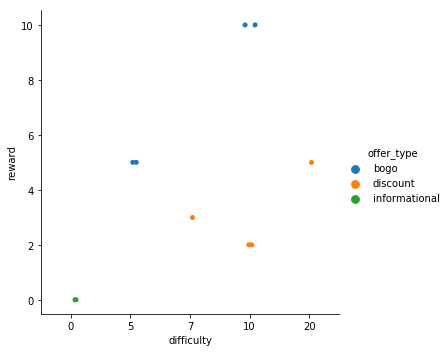

In [10]:
g = sns.catplot(x='difficulty', y='reward', hue='offer_type', data=portfolio,
                hue_order=['bogo', 'discount','informational'])
g.savefig("images/portfolio-difficulty_vs_reward-hue_offer_type.png")

**Notes:**

On the whole, discount offer is significantly more difficult, but those offer is also valid for a longer period of view. 

BOGO offer means buy one get one free, that is, paying the specified amount and getting a double item. It makes sense for BOGO offer to be less difficult, because its difficulty is completely positively correlated with the rewards that the business needs to provide. 

In addition, there is no discount for informational offers. These offer may be advertisements for new goods, or it may be a notice of the time limit for special goods to be issued.

**TODO:**

- Field `channels` looks like it needs cleaning.
- Field `channels` can be transformed into some dummy variables.
- Field `id` need to be simplified.
- Field `offer_type` can be transformed into some dummy variables.
- Only when the type of offer is `informational`, `difficulty` and `reward` value will be `0`.

### 1.2 Profile

In [11]:
print(profile.shape)
profile.head()

(17000, 5)


,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [12]:
profile[profile['age']==118].shape[0],\
profile[profile['gender'].isnull()].shape[0],\
profile[profile['income'].isnull()].shape[0],\
profile[(profile['age']==118) | 
        (profile['gender'].isnull()) | 
        (profile['income'].isnull())].shape[0]

(2175, 2175, 2175, 2175)

In [13]:
profile[profile['age']==118].shape[0]/profile.shape[0]

0.12794117647058822

**Notes:**

In order to avoid a significant impact on the original distribution of the data, and in order to maintain the original amount of data, I can not delete these invalid data. I need to fill them. For missing values in the "age" column, I fill in the values using a backward fill. That is, for the current missing value, I will fill it with the value of the same column in the next line. Because the "gender" column stores data of a fixed class scale, I fill a new value called "U" for its missing value, which means "unknown". For missing values in the "income" column, I also use the way to fill backwards.

In [14]:
# handle missing values
profile_filled = profile.copy()

profile_filled['age'] = profile_filled['age'].apply(
    lambda x: np.nan if x==118 else x)
profile_filled['age'] = profile_filled['age'].fillna(method='bfill')
profile_filled['gender'] = profile_filled['gender'].fillna('U')
profile_filled['income'] = profile_filled['income'].fillna(method='bfill')

print(profile_filled.isnull().sum())

profile_filled.head()

age                 0
became_member_on    0
gender              0
id                  0
income              0
dtype: int64


,age,became_member_on,gender,id,income
0,55.0,20170212,U,68be06ca386d4c31939f3a4f0e3dd783,112000.0
1,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,75.0,20180712,U,38fe809add3b4fcf9315a9694bb96ff5,100000.0
3,75.0,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,68.0,20170804,U,a03223e636434f42ac4c3df47e8bac43,70000.0


In [15]:
profile_filled['age'].describe()

count    17000.000000
mean        54.329941
std         17.373716
min         18.000000
25%         42.000000
50%         55.000000
75%         66.000000
max        101.000000
Name: age, dtype: float64

In [16]:
profile[profile['age']!=118]['age'].describe()

count    14825.000000
mean        54.393524
std         17.383705
min         18.000000
25%         42.000000
50%         55.000000
75%         66.000000
max        101.000000
Name: age, dtype: float64

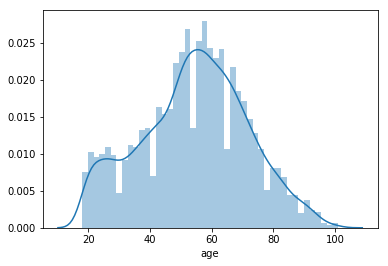

In [17]:
sns.distplot(profile_filled['age'])
plt.savefig("images/profile-age_dist.png")

In [18]:
profile_filled['gender'].value_counts()

M    8484
F    6129
U    2175
O     212
Name: gender, dtype: int64

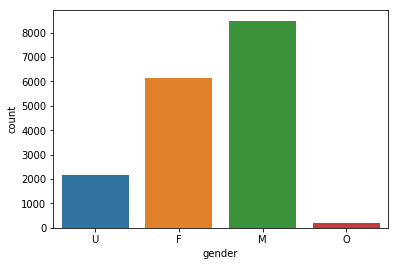

In [19]:
sns.countplot(x='gender', data=profile_filled)
plt.savefig("images/profile-gender_count.png")

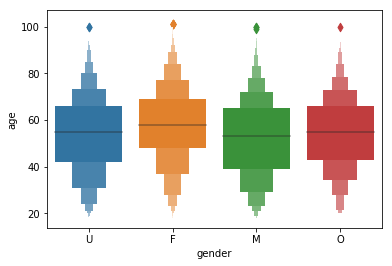

In [20]:
sns.boxenplot(x="gender", y="age", data=profile_filled)
plt.savefig("images/profile-gender_vs_age-boxen.png")

In [21]:
profile_filled.groupby('gender')['age'].median()

gender
F    58.0
M    53.0
O    55.0
U    55.0
Name: age, dtype: float64

In [22]:
profile_filled.groupby('gender')['age'].std()

gender
F    16.883315
M    17.413894
O    16.244710
U    17.303234
Name: age, dtype: float64

**Notes**

The age distribution of customers of different genders is also different. Overall, female customers are older, male customers are younger, and the age of the other and the unknown customers is in the middle.

In [23]:
profile_filled['income'].describe()

count     17000.000000
mean      65405.647059
std       21600.135108
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

In [24]:
profile[profile['income'].notnull()]['income'].describe()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

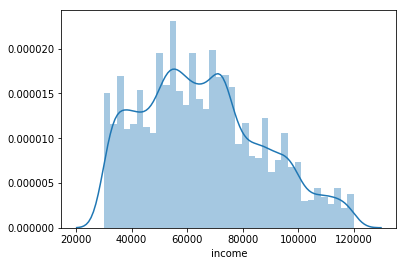

In [25]:
sns.distplot(profile_filled['income'])
plt.savefig("images/profile-income_dist.png")

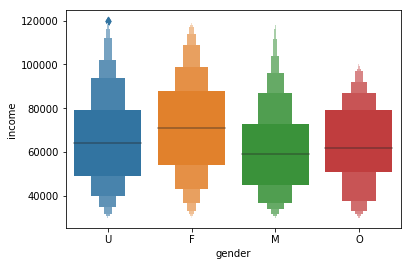

In [26]:
sns.boxenplot(x="gender", y="income", data=profile_filled)
plt.savefig("images/profile-gender_vs_income-boxen.png")

In [27]:
profile_filled.groupby('gender')['income'].median()

gender
F    71000.0
M    59000.0
O    62000.0
U    64000.0
Name: income, dtype: float64

In [28]:
profile_filled.groupby('gender')['income'].std()

gender
F    22338.353773
M    20069.517615
O    18938.594726
U    21617.612005
Name: income, dtype: float64

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

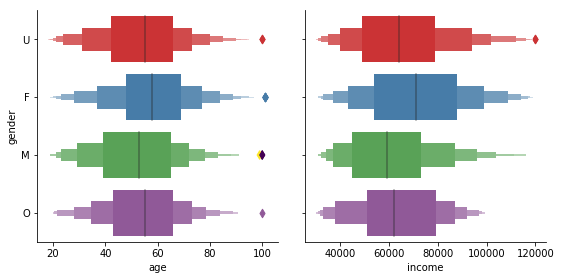

In [29]:
g = sns.PairGrid(profile_filled, 
                 y_vars='gender', x_vars=['age', 'income'], 
                 height=4)
g.map(sns.boxenplot, palette='Set1')
plt.savefig("images/profile-gender_vs_age_and_income-boxen.png")

**TODO:**

- Field `age` looks like it needs cleaning. `118` represents the missing value. 
- Field `became_member_on` can be transformed into some dummy variables.
- Field `gender` need to be cleaned, and can be transformed into some dummy variables.
- Field `id` need to be simplified.
- Field `income` need to be cleaned.
- There are `2175` invalid sample points.

### 1.3 Transcript

In [30]:
print(transcript.shape)
transcript.head()

(306534, 4)


,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [31]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

**Notes**

For the value of the "event" column (or the type of event), I find that there are some rules to follow. For example, "offer received," "offer viewed" and "offer completed" are linked in number. That is, the number of events of the "offer received" type is the largest of the three, with the number of events of the "offer viewed" type being the second, and the number of events of the "offer completed" type being the fewest.

This is reasonable and in line with the funnel model. However, events of the "transaction" type are different from them. The number of the former is an order of magnitude higher than the number of the latter. This also means that many transactions cannot correspond to the customer's response to the offer.

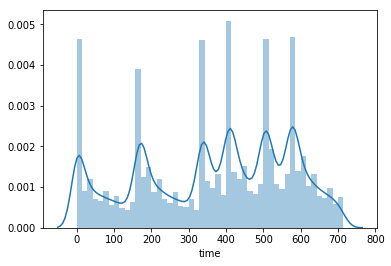

In [32]:
sns.distplot(transcript['time'])

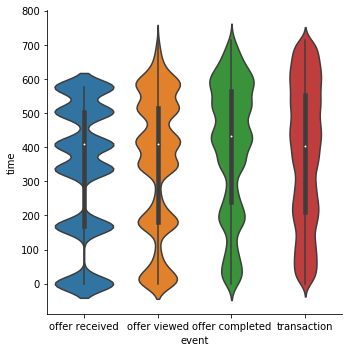

In [33]:
sns.catplot(x="event", y="time", data=transcript, kind="violin",
            order=['offer received',
                   'offer viewed',
                   'offer completed', 
                   'transaction'])
plt.savefig("images/transcript-event_vs_time-violin.png")

**Notes**

From this violin diagram, we can see that there is a more obvious time delay effect between the "offer received", "offer viewed" and "offer completed" types of events. We can appreciate this from the wavy lines in the diagram. The offer is sent to the customer first. Some customers will see these offer in the near future. After a while, some of the customers will respond to the offer. There will be some echoes of the "transaction" type of event, but it is not obvious.

In [34]:
transcript[transcript['event']=='transaction'].head(1)

,event,person,time,value
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001}


**TODO:**

- Field `event` can be transformed into some dummy variables.
- Field `person` need to be simplified.
- Field `value` need to be cleaned, and can be transformed into some dummy variables.

## 2. Data cleaning <a name="#data cleaning"></a>

### 2.1 Portfolio

In [35]:
# clean portfolio
offer_id_map = gen.gen_id_map(portfolio['id'])

portfolio_cleaned = cln.clean_portfolio_df(portfolio, offer_id_map)

print(portfolio_cleaned.shape)

portfolio_cleaned

(10, 9)


,offer_id,offer_type,difficulty,duration,reward,channel_email,channel_mobile,channel_social,channel_web
0,1,bogo,10,7,10,1,1,1,0
1,2,bogo,10,5,10,1,1,1,1
2,3,informational,0,4,0,1,1,0,1
3,4,bogo,5,7,5,1,1,0,1
4,5,discount,20,10,5,1,0,0,1
5,6,discount,7,7,3,1,1,1,1
6,7,discount,10,10,2,1,1,1,1
7,8,informational,0,3,0,1,1,1,0
8,9,bogo,5,5,5,1,1,1,1
9,10,discount,10,7,2,1,1,0,1


**Notes**

I cleaned up the data in the portfolio. First, the values in the "channels" column are actually stored as a list. I split the values of each element in the list represented by these values and establish a separate column for each individual element value. In other words, I implemented a preprocessing called one-hot encoding on the "channels" column. I then replaced the value of the "id" column with a number (or serial number) because I thought it would make the ID of the offer more meaningful and would make the program execute faster. Finally, I rearranged the columns in the portfolio.

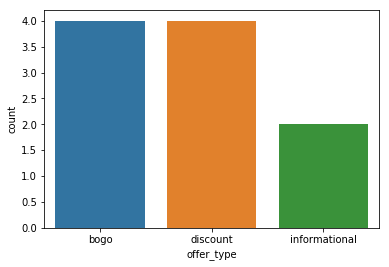

In [36]:
sns.countplot(x="offer_type", data=portfolio_cleaned, 
              order=['bogo', 'discount','informational'])

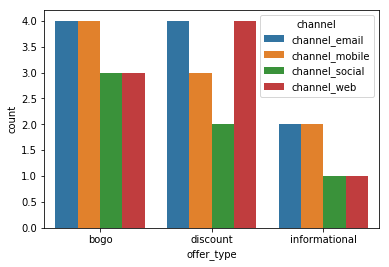

In [37]:
channel_types = ['channel_email', 'channel_mobile', 'channel_social', 'channel_web']
channel_count_df = portfolio_cleaned.groupby(by='offer_type')[channel_types].sum()
channel_count_df = channel_count_df.stack(level=0)
channel_count_df = channel_count_df.reset_index()
channel_count_df.columns = ['offer_type', 'channel', 'count']
# channel_count_df

sns.barplot(x="offer_type", y="count", hue='channel', data=channel_count_df)
plt.savefig("images/portfolio_cleaned-channel_count.png")

**Notes:**

We can simply group the cleaned portfolio to see the number of offer sent to customers through different channels. For BOGO offer, Starbucks is sent more through "email" and "mobile" channels. And for discount offer, they tend to send it through "email" and "web" channels. By the way, all offer will be sent via the "email" channel.

### 2.2 Profile

In [38]:
# clean profile 
profile_id_map = gen.gen_id_map(profile['id'])

profile_cleaned = cln.clean_profile_df(profile, profile_id_map, True, False)

print(profile_cleaned.shape)

profile_cleaned.head()

(17000, 8)


,profile_id,gender,age,age_backet,income,income_backet,reg_year,reg_month
0,1,U,55.0,"(50, 60]",112000.0,"(110000, 120000]",2017,2
1,2,F,55.0,"(50, 60]",112000.0,"(110000, 120000]",2017,7
2,3,U,75.0,"(70, 80]",100000.0,"(90000, 100000]",2018,7
3,4,F,75.0,"(70, 80]",100000.0,"(90000, 100000]",2017,5
4,5,U,68.0,"(60, 70]",70000.0,"(60000, 70000]",2017,8


**Notes:**

I cleaned up the data in profile. This includes those processes that I said earlier about the missing values in it. In addition, I replaced its "id" with the serial number. 

The "became_member_on" column represents the date on which the customer is registered as a Starbucks member. I split the values in the column to represent the two parts of year and month, and put them in a new column called "reg_year" and "reg_month", respectively. Note that I have taken out the information about "day" in the registration date. Because I don't think they have much effect on subsequent analysis. 

In addition, I have discretized the "age" column and the "income" column. That is, I put the values in the buckets that represent different segments, depending on their size. The names of the new columns are called "age_backet" and "income_backet". Obviously, they store data with nominal level. However, I have reserved the "age" column and the "income" column. I think they can play a different role in the analysis that follows.

In [39]:
profile_cleaned['gender'].value_counts()

M    8484
F    6129
U    2175
O     212
Name: gender, dtype: int64

In [40]:
profile_cleaned[profile_cleaned['gender']=='O'].shape[0]/profile_cleaned[
    profile_cleaned['gender']!='U'].shape[0]

0.014300168634064081

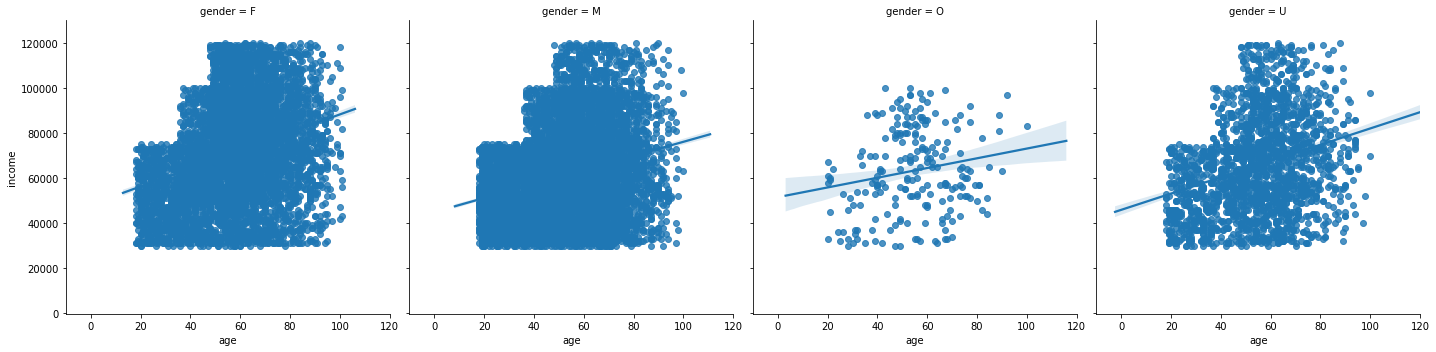

In [41]:
ordered_genders = ['F', 'M', 'O', 'U']

g = sns.lmplot(x="age", y="income", col="gender", data=profile_cleaned, 
               col_order=ordered_genders, height=5);
g.set(xlim=(-10, 120), ylim=(-200, 130000));
plt.savefig("images/profile_cleaned-age_vs_income-hue_gender.png")

**Notes**

After cleaning, we can draw a scatter plot with a linear fitting line. Through this picture, we can easily see the correlation between age and income. There is a positively correlated relationship between them. Thanks to the "age_backet" column and the "income_backet" column, we can also look at the relationship between age and income from more angles.

In [42]:
profile_cleaned['age_backet'].value_counts()

(50, 60]      4111
(60, 70]      3369
(40, 50]      2744
(70, 80]      1867
(30, 40]      1821
(20, 30]      1575
(80, 90]       869
(0, 20]        395
(90, 100]      244
(100, 120]       5
Name: age_backet, dtype: int64

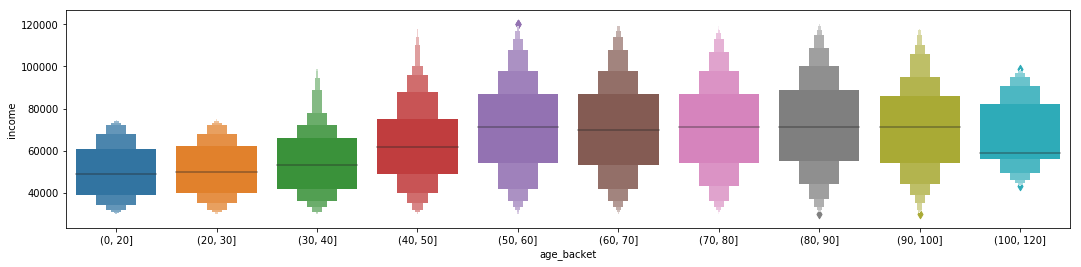

In [43]:
ordered_age_backets = ['(0, 20]', '(20, 30]', '(30, 40]', '(40, 50]', 
                       '(50, 60]', '(60, 70]', '(70, 80]', '(80, 90]', 
                       '(90, 100]', '(100, 120]']

plt.figure(figsize=(18, 4))
sns.boxenplot(x="age_backet", y="income", data=profile_cleaned,
             order=ordered_age_backets)
plt.savefig("images/profile_cleaned-age_backet_vs_income.png")

In [44]:
profile_cleaned['income_backet'].value_counts()

(50000, 60000]      3048
(60000, 70000]      2699
(70000, 80000]      2541
(30000, 40000]      2328
(40000, 50000]      2205
(80000, 90000]      1563
(90000, 100000]     1368
(100000, 110000]     617
(110000, 120000]     531
(0, 30000]           100
Name: income_backet, dtype: int64

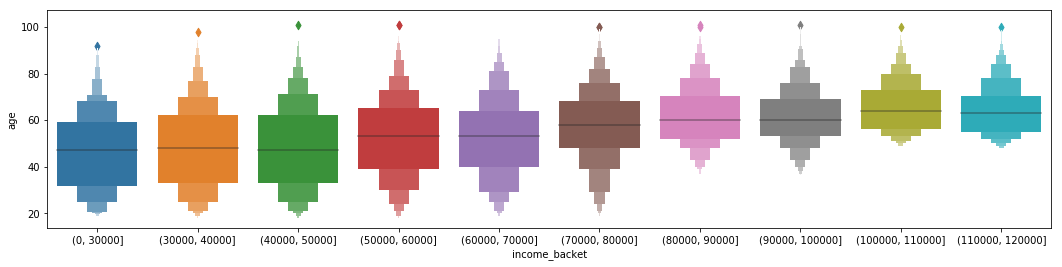

In [45]:
ordered_income_backets = ['(0, 30000]', '(30000, 40000]', '(40000, 50000]', 
                          '(50000, 60000]', '(60000, 70000]', '(70000, 80000]', 
                          '(80000, 90000]', '(90000, 100000]', '(100000, 110000]',
                          '(110000, 120000]']

plt.figure(figsize=(18, 4))
sns.boxenplot(x="income_backet", y="age", data=profile_cleaned,
             order=ordered_income_backets)
plt.savefig("images/profile_cleaned-income_backet_vs_age.png")

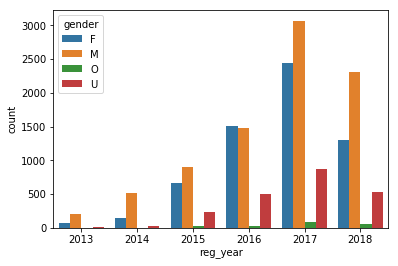

In [46]:
sns.countplot(x="reg_year", hue="gender", data=profile_cleaned,
             hue_order=ordered_genders)
plt.savefig("images/profile_cleaned-reg_year_count-hue_gender.png")

**Notes**

Let's take another look at the year in which customers register as Starbucks members. As we can see from the histogram, the largest number of customers were registered in 2017. And, most of the time, there will be more registered male customers than female customers. However, the months in which they registered were relatively average.

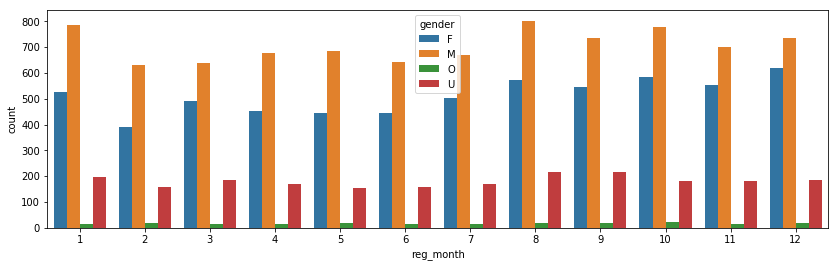

In [47]:
plt.figure(figsize=(14, 4))
sns.countplot(x="reg_month", hue="gender", data=profile_cleaned,
             hue_order=ordered_genders)

plt.savefig("images/profile_cleaned-reg_month_count-hue_gender.png")

### 2.3 Transcript

In [48]:
# clean transcript
transcript_cleaned = cln.clean_transcript_df(transcript, offer_id_map, profile_id_map)

print(transcript_cleaned.shape)

transcript_cleaned.tail()

(306534, 7)


,event_id,event,event_amount,event_reward,time,profile_id,offer_id
306529,306530,transaction,1.59,0,714,16960,0
306530,306531,transaction,9.53,0,714,16965,0
306531,306532,transaction,3.61,0,714,16980,0
306532,306533,transaction,3.53,0,714,16988,0
306533,306534,transaction,4.05,0,714,16995,0


In [49]:
transcript_cleaned['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [50]:
transcript_cleaned['event_amount'].describe()

count    306534.000000
mean          5.792023
std          21.337137
min           0.000000
25%           0.000000
50%           0.000000
75%           7.100000
max        1062.280000
Name: event_amount, dtype: float64

In [51]:
transcript_cleaned.sort_values(by='event_amount', ascending=False).head()

,event_id,event,event_amount,event_reward,time,profile_id,offer_id
284273,284274,transaction,1062.28,0,630,2682,0
301790,301791,transaction,1015.73,0,690,15562,0
42253,42254,transaction,1001.85,0,102,3136,0
140346,140347,transaction,989.34,0,372,6919,0
302951,302952,transaction,977.78,0,696,13212,0


In [52]:
transcript_cleaned.sort_values(by=['event_reward'], ascending=False).head()

,event_id,event,event_amount,event_reward,time,profile_id,offer_id
295659,295660,offer completed,0.0,10,666,9798,1
265594,265595,offer completed,0.0,10,582,16883,2
166585,166586,offer completed,0.0,10,408,12898,2
274386,274387,offer completed,0.0,10,600,16213,2
179980,179981,offer completed,0.0,10,438,247,2


In [53]:
# for informational offers
(len(transcript_cleaned[(transcript_cleaned['offer_id']==3) &
                    (transcript_cleaned['event']=='offer completed')].values),
len(transcript_cleaned[(transcript_cleaned['offer_id']==8) &
                   (transcript_cleaned['event']=='offer completed')].values))

(0, 0)

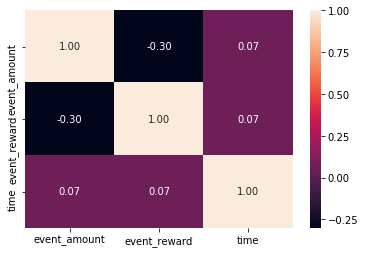

In [54]:
transcript_cleaned_corr = transcript_cleaned.drop(
    ['event_id', 'profile_id', 'offer_id'], axis=1)
sns.heatmap(transcript_cleaned_corr.corr(method='spearman'), annot=True, fmt=".2f")

## 3. Data transformation

In [55]:
# create the data frame about the response
start_time = time.time()

response = cbn.create_response(transcript_cleaned)

end_time = time.time()
print('The time spent creating data frame named response: {}s'.\
      format(end_time - start_time))

print(response.shape)

response.head()

The time spent creating data frame named response: 61.42976689338684s
(63288, 6)


,response,profile_id,offer_id,resp_number,resp_amount,resp_reward
0,0,1,5,0,0.00,0
1,1,1,6,1,2.12,3
2,1,1,7,1,2.12,2
3,0,1,10,0,0.00,0
4,0,2,3,0,0.00,0


**Notes:**

By looking at only the data about offer, customers and events separately, we are always able to analyze and not come up with useful results.

We need to combine that data. The way I merge data is centered on the data in transcript. Because in transcript there is both the ID of the offer and the customer's ID.

First, I created a new data frame with the name "response" based on the cleaned transcript. During the creation process, I first group all event records according to the customer's ID and the ID of the offer. Doing so will lead to groups that will include a record of events that occur between a customer and an offer, respectively. From this we can determine whether each customer has responded validly to the offer he received, as well as the number of responses. The criterion for judgment is that for a customer and an offer, if the three types of events "offer received", "offer viewed", and "offer completed" occur continuously (sorted according to "time"), then a valid response is recorded. If it happens multiple times, it means that the customer has responded validly to the offer several times. This is the main algorithm.


Note that:

    1. Even if a customer is rewarded for completing an offer, it does not indicate that he has responded validly to the offer. Because he may have happened to complete the offer without looking at the offer. 
    2. We cannot count the valid response to the informational offer, as there will be no event records of the "offer completed" type of such offer at all.

In [56]:
transcript_cleaned[transcript_cleaned['event']=='offer completed'].shape[0]

33579

In [57]:
n_row = response.shape[0]
n_row_resp1 = response[response['response']==1].shape[0]

(n_row, n_row_resp1, n_row_resp1/n_row)

(63288, 21371, 0.3376785488560233)

**Notes:**

In transcript, there are 33579 event records of type "offer completed". This means that the number of valid responses recorded in it is unlikely to be greater than 33597.

As a result of the above calculations, a total of 63288 connections occurred between the customer and the offer. Of these, 21371 were judged to be valid responses, accounting for 33.77% of the total.

In [58]:
response[response['offer_id']==7].head()

,response,profile_id,offer_id,resp_number,resp_amount,resp_reward
2,1,1,7,1,2.12,2
17,1,6,7,1,18.42,2
21,0,7,7,0,0.00,0
29,1,9,7,1,11.26,2
43,1,13,7,1,7.14,2


In [59]:
response[response['profile_id']==9]

,response,profile_id,offer_id,resp_number,resp_amount,resp_reward
28,1,9,4,1,15.63,5
29,1,9,7,1,11.26,2
30,1,9,9,2,20.80,10
31,1,9,10,1,15.63,2


In [60]:
# merge response
response_merged = cbn.merge_response(
    response, portfolio_cleaned, profile_cleaned)

print(response_merged.shape)

response_merged.head()

(63288, 21)


,response,profile_id,offer_id,resp_number,resp_amount,resp_reward,offer_type,difficulty,duration,reward,...,channel_mobile,channel_social,channel_web,gender,age,age_backet,income,income_backet,reg_year,reg_month
0,0,1,5,0,0.00,0,discount,20,10,5,...,0,0,1,U,55.0,"(50, 60]",112000.0,"(110000, 120000]",2017,2
1,1,1,6,1,2.12,3,discount,7,7,3,...,1,1,1,U,55.0,"(50, 60]",112000.0,"(110000, 120000]",2017,2
2,1,1,7,1,2.12,2,discount,10,10,2,...,1,1,1,U,55.0,"(50, 60]",112000.0,"(110000, 120000]",2017,2
3,0,1,10,0,0.00,0,discount,10,7,2,...,1,0,1,U,55.0,"(50, 60]",112000.0,"(110000, 120000]",2017,2
4,0,2,3,0,0.00,0,informational,0,4,0,...,1,0,1,F,55.0,"(50, 60]",112000.0,"(110000, 120000]",2017,7


**Notes:**

In the second step, I need to use the response data frame as the center to merge the data from the cleaned portfolio and profile. This is mainly to connect more information about customers and offers. This step is very simple, but it is necessary.

In [61]:
# Attention! Drop the rows about informational offer.
response_merged = response_merged[response_merged['offer_type']!='informational']

print(response_merged.shape)

response_merged['offer_type'].value_counts()

(50637, 21)


bogo        25321
discount    25316
Name: offer_type, dtype: int64

In [62]:
response_multiresponse = response_merged[response_merged['resp_number']>1]

print(response_multiresponse.shape)
print(response_multiresponse['offer_type'].value_counts())

response_multiresponse.head()

(2244, 21)
discount    1209
bogo        1035
Name: offer_type, dtype: int64


,response,profile_id,offer_id,resp_number,resp_amount,resp_reward,offer_type,difficulty,duration,reward,...,channel_mobile,channel_social,channel_web,gender,age,age_backet,income,income_backet,reg_year,reg_month
30,1,9,9,2,20.80,10,bogo,5,5,5,...,1,1,1,M,65.0,"(60, 70]",53000.0,"(50000, 60000]",2018,2
53,1,16,6,2,27.58,6,discount,7,7,3,...,1,1,1,F,62.0,"(60, 70]",71000.0,"(70000, 80000]",2016,2
71,1,21,6,3,43.21,9,discount,7,7,3,...,1,1,1,F,40.0,"(30, 40]",71000.0,"(70000, 80000]",2016,5
86,1,25,7,2,46.51,4,discount,10,10,2,...,1,1,1,M,42.0,"(40, 50]",69000.0,"(60000, 70000]",2013,8
89,1,26,5,2,55.71,10,discount,20,10,5,...,0,0,1,F,56.0,"(50, 60]",88000.0,"(80000, 90000]",2018,4


In [63]:
response_merged.sort_values(by=['resp_amount'], ascending=False).head()

,response,profile_id,offer_id,resp_number,resp_amount,resp_reward,offer_type,difficulty,duration,reward,...,channel_mobile,channel_social,channel_web,gender,age,age_backet,income,income_backet,reg_year,reg_month
25758,1,6919,7,3,1033.78,6,discount,10,10,2,...,1,1,1,F,53.0,"(50, 60]",110000.0,"(100000, 110000]",2016,2
57944,1,15562,2,1,1015.73,10,bogo,10,5,10,...,1,1,1,F,53.0,"(50, 60]",89000.0,"(80000, 90000]",2018,3
31889,1,8554,9,2,966.99,10,bogo,5,5,5,...,1,1,1,F,47.0,"(40, 50]",97000.0,"(90000, 100000]",2014,6
24913,1,6690,9,1,919.16,5,bogo,5,5,5,...,1,1,1,F,70.0,"(60, 70]",105000.0,"(100000, 110000]",2015,7
34361,1,9212,5,2,877.17,10,discount,20,10,5,...,0,0,1,F,74.0,"(70, 80]",117000.0,"(110000, 120000]",2017,10


In [64]:
response_merged.sort_values(by=['resp_reward'], ascending=False).head()

,response,profile_id,offer_id,resp_number,resp_amount,resp_reward,offer_type,difficulty,duration,reward,...,channel_mobile,channel_social,channel_web,gender,age,age_backet,income,income_backet,reg_year,reg_month
32732,1,8776,1,4,52.26,40,bogo,10,7,10,...,1,1,0,M,61.0,"(60, 70]",44000.0,"(40000, 50000]",2016,1
21638,1,5817,2,4,59.25,40,bogo,10,5,10,...,1,1,1,F,66.0,"(60, 70]",55000.0,"(50000, 60000]",2017,10
16342,1,4387,1,4,124.82,40,bogo,10,7,10,...,1,1,0,F,48.0,"(40, 50]",85000.0,"(80000, 90000]",2016,1
323,1,89,2,3,39.92,30,bogo,10,5,10,...,1,1,1,M,78.0,"(70, 80]",58000.0,"(50000, 60000]",2015,11
1393,1,377,2,3,421.31,30,bogo,10,5,10,...,1,1,1,F,24.0,"(20, 30]",59000.0,"(50000, 60000]",2017,2


In [65]:
# Offer-oriented statistical event data
offer_groups = response_merged.groupby(by=['offer_type', 'offer_id'])[
    'response', 'resp_number', 'resp_amount', 'resp_reward']

offer_groups_df = offer_groups.mean()
offer_groups_df = offer_groups_df.stack(level=0)
offer_groups_df = offer_groups_df.reset_index()
offer_groups_df.columns = ['offer_type', 'offer_id', 'resp_fields', 'mean']

offer_groups_df

,offer_type,offer_id,resp_fields,mean
0,bogo,1,response,0.375431
1,bogo,1,resp_number,0.416536
2,bogo,1,resp_amount,9.898053
3,bogo,1,resp_reward,4.165359
4,bogo,2,response,0.392259
5,bogo,2,resp_number,0.439968
6,bogo,2,resp_amount,10.555245
7,bogo,2,resp_reward,4.399684
8,bogo,4,response,0.319748
9,bogo,4,resp_number,0.345397


In [66]:
print(response_merged.groupby('offer_type')['response'].mean())

offer_groups_df[offer_groups_df['resp_fields']=='response']

offer_type
bogo        0.399392
discount    0.444699
Name: response, dtype: float64


,offer_type,offer_id,resp_fields,mean
0,bogo,1,response,0.375431
4,bogo,2,response,0.392259
8,bogo,4,response,0.319748
12,bogo,9,response,0.511817
16,discount,5,response,0.198149
20,discount,6,response,0.615810
24,discount,7,response,0.647663
28,discount,10,response,0.318059


In [67]:
print(response_merged.groupby('offer_type')['resp_number'].mean())

offer_groups_df[offer_groups_df['resp_fields']=='resp_number']

offer_type
bogo        0.442755
discount    0.495497
Name: resp_number, dtype: float64


,offer_type,offer_id,resp_fields,mean
1,bogo,1,resp_number,0.416536
5,bogo,2,resp_number,0.439968
9,bogo,4,resp_number,0.345397
13,bogo,9,resp_number,0.571064
17,discount,5,resp_number,0.210700
21,discount,6,resp_number,0.693913
25,discount,7,resp_number,0.730733
29,discount,10,resp_number,0.347653


**Notes:**

Overall, the ratio of customers responding to BOGO offers and discount offers is not the same. The rate of customers responding to discount offer is significantly larger. Besides, some customers will respond to the same offer multiple times. The discount offers are still better in this respect.

In [68]:
offer_id_ordered = offer_groups_df[
    offer_groups_df['resp_fields']=='response'].sort_values(
    by=['mean'], ascending=False)['offer_id'].values

print(offer_id_ordered)

portfolio_ordered = portfolio_cleaned.copy()

portfolio_ordered = portfolio_ordered[portfolio_ordered['offer_type']!='informational']

portfolio_ordered.insert(0, 'ranking', np.nan)

rank_map = {}
for index, offer_id in enumerate(offer_id_ordered):
    rank_map[offer_id] = index + 1

portfolio_ordered['ranking'] = [rank_map[row['offer_id']] 
                                for _, row in portfolio_ordered.iterrows()]

portfolio_ordered.sort_values(by='ranking')

[ 7  6  9  2  1  4 10  5]


,ranking,offer_id,offer_type,difficulty,duration,reward,channel_email,channel_mobile,channel_social,channel_web
6,1,7,discount,10,10,2,1,1,1,1
5,2,6,discount,7,7,3,1,1,1,1
8,3,9,bogo,5,5,5,1,1,1,1
1,4,2,bogo,10,5,10,1,1,1,1
0,5,1,bogo,10,7,10,1,1,1,0
3,6,4,bogo,5,7,5,1,1,0,1
9,7,10,discount,10,7,2,1,1,0,1
4,8,5,discount,20,10,5,1,0,0,1


In [69]:
portfolio_ordered.sort_values(by=['offer_type', 'ranking'])

,ranking,offer_id,offer_type,difficulty,duration,reward,channel_email,channel_mobile,channel_social,channel_web
8,3,9,bogo,5,5,5,1,1,1,1
1,4,2,bogo,10,5,10,1,1,1,1
0,5,1,bogo,10,7,10,1,1,1,0
3,6,4,bogo,5,7,5,1,1,0,1
6,1,7,discount,10,10,2,1,1,1,1
5,2,6,discount,7,7,3,1,1,1,1
9,7,10,discount,10,7,2,1,1,0,1
4,8,5,discount,20,10,5,1,0,0,1


**Notes:**

From the perspective of ranking, I did not find the rule related to the features of offer.

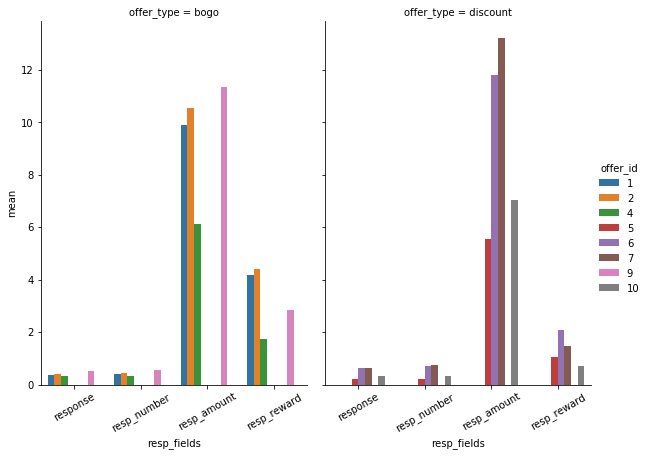

In [70]:
g = sns.catplot(x="resp_fields", y="mean", hue="offer_id", col="offer_type", 
                data=offer_groups_df, kind="bar", height=6, aspect=.7)
_ = [plt.setp(ax.get_xticklabels(), rotation=30) for ax in g.axes.flat]

g.savefig("images/response_merged-offer_groups-resp_fields_vs_mean.png")

**Notes:**

The above is the statistics of valid response to offer. Let's take a look at the statistics of customer-oriented valid responses.

In [71]:
def create_counts_df(response_merged, groupby, measure='mean'):
    """Creates a data frame that counts response data according to the specified grouping.
    """
    groupByObj = response_merged.groupby(by=groupby)[
        'response', 'resp_number', 'resp_amount', 'resp_reward']
    
    if measure == 'std':
        df = groupByObj.std()
    else:
        df = groupByObj.mean()

    df = df.stack(level=0)
    df = df.reset_index()
    
    col_names = []
    if isinstance(groupby, list):
        col_names.extend(groupby)
    else:
        col_names.append(groupby)
    
    df.columns = col_names + ['resp_fields', measure]

    return df

In [72]:
counts_mean_gender = create_counts_df(response_merged, ['gender', 'profile_id'])

counts_mean_gender.head()

,gender,profile_id,resp_fields,mean
0,F,2,response,0.000000
1,F,2,resp_number,0.000000
2,F,2,resp_amount,0.000000
3,F,2,resp_reward,0.000000
4,F,4,response,0.666667


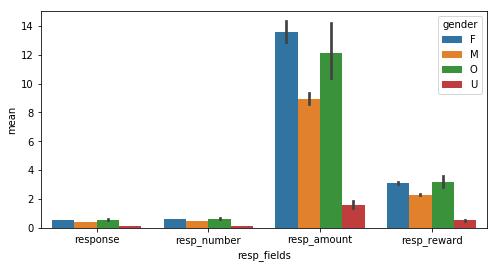

In [73]:
plt.figure(figsize=(8, 4))
g = sns.barplot(x="resp_fields", y="mean", hue='gender', data=counts_mean_gender,
                hue_order=ordered_genders)
plt.savefig("images/response_merged-profile_groups-resp_fields_vs_mean-hue_gender.png")

**Notes:**
    
The longitudinal thick line on the histogram indicates what range the average number of offer responses per customer of a particular gender is within.

Apparently, women spend the most money on average.

In [74]:
create_counts_df(response_merged, ['gender'])

,gender,resp_fields,mean
0,F,response,0.521942
1,F,resp_number,0.584281
2,F,resp_amount,13.063232
3,F,resp_reward,3.018070
4,M,response,0.417731
5,M,resp_number,0.464049
6,M,resp_amount,8.749745
7,M,resp_reward,2.226861
8,O,response,0.580858
9,O,resp_number,0.645215


**Notes:**

Surprisingly, the number of customers of other genders is very small, but they also perform very well in this aspect, ranking the second place. For the average of responses, the average of response numbers and the average of rewards, the performance of these customers even ranked first.

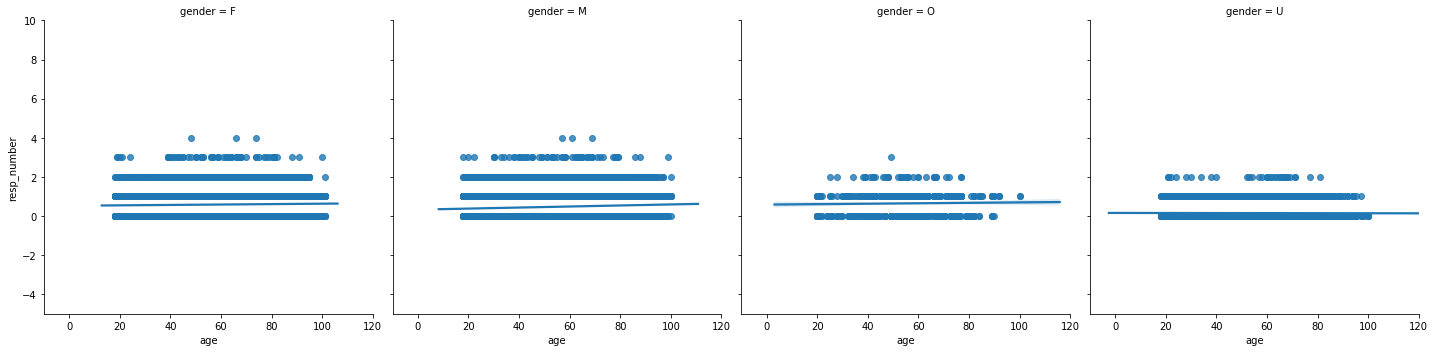

In [75]:
g = sns.lmplot(x="age", y="resp_number", col="gender", data=response_merged, 
               col_order=ordered_genders, height=5);
g.set(xlim=(-10, 120), ylim=(-5, 10));
plt.savefig("images/response_merged-age_vs_resp_number-hue_gender.png")

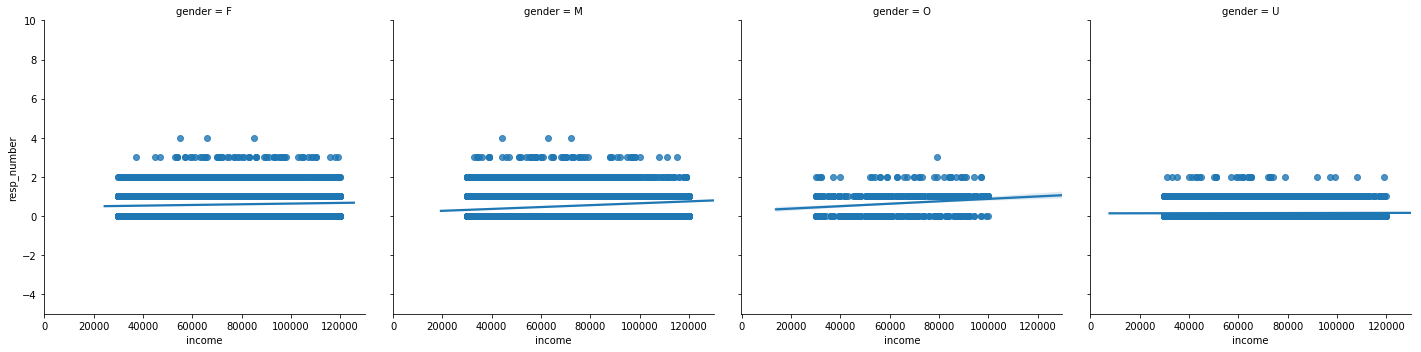

In [76]:
g = sns.lmplot(x="income", y="resp_number", col="gender", data=response_merged, 
               col_order=ordered_genders, height=5);
g.set(xlim=(-200, 130000), ylim=(-5, 10));
plt.savefig("images/response_merged-income_vs_resp_number-hue_gender.png")

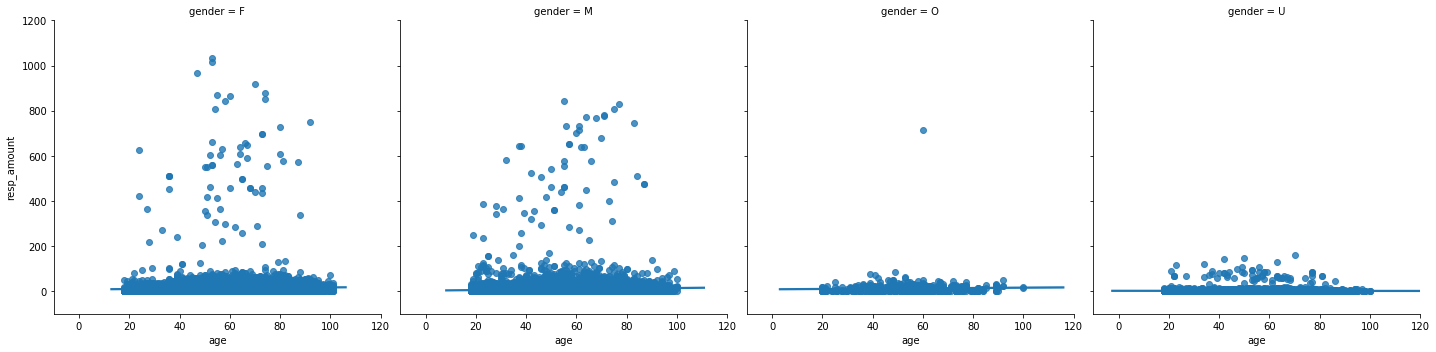

In [77]:
g = sns.lmplot(x="age", y="resp_amount", col="gender", data=response_merged, 
               col_order=ordered_genders, height=5);
g.set(xlim=(-10, 120), ylim=(-100, 1200));
plt.savefig("images/response_merged-age_vs_resp_amount-hue_gender.png")

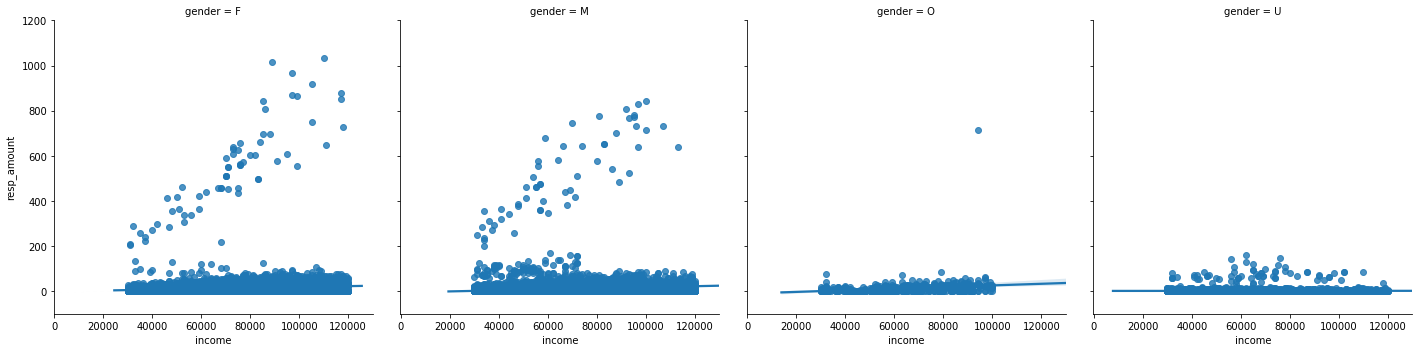

In [78]:
g = sns.lmplot(x="income", y="resp_amount", col="gender", data=response_merged, 
               col_order=ordered_genders, height=5);
g.set(xlim=(-200, 130000), ylim=(-100, 1200));
plt.savefig("images/response_merged-income_vs_resp_amount-hue_gender.png")

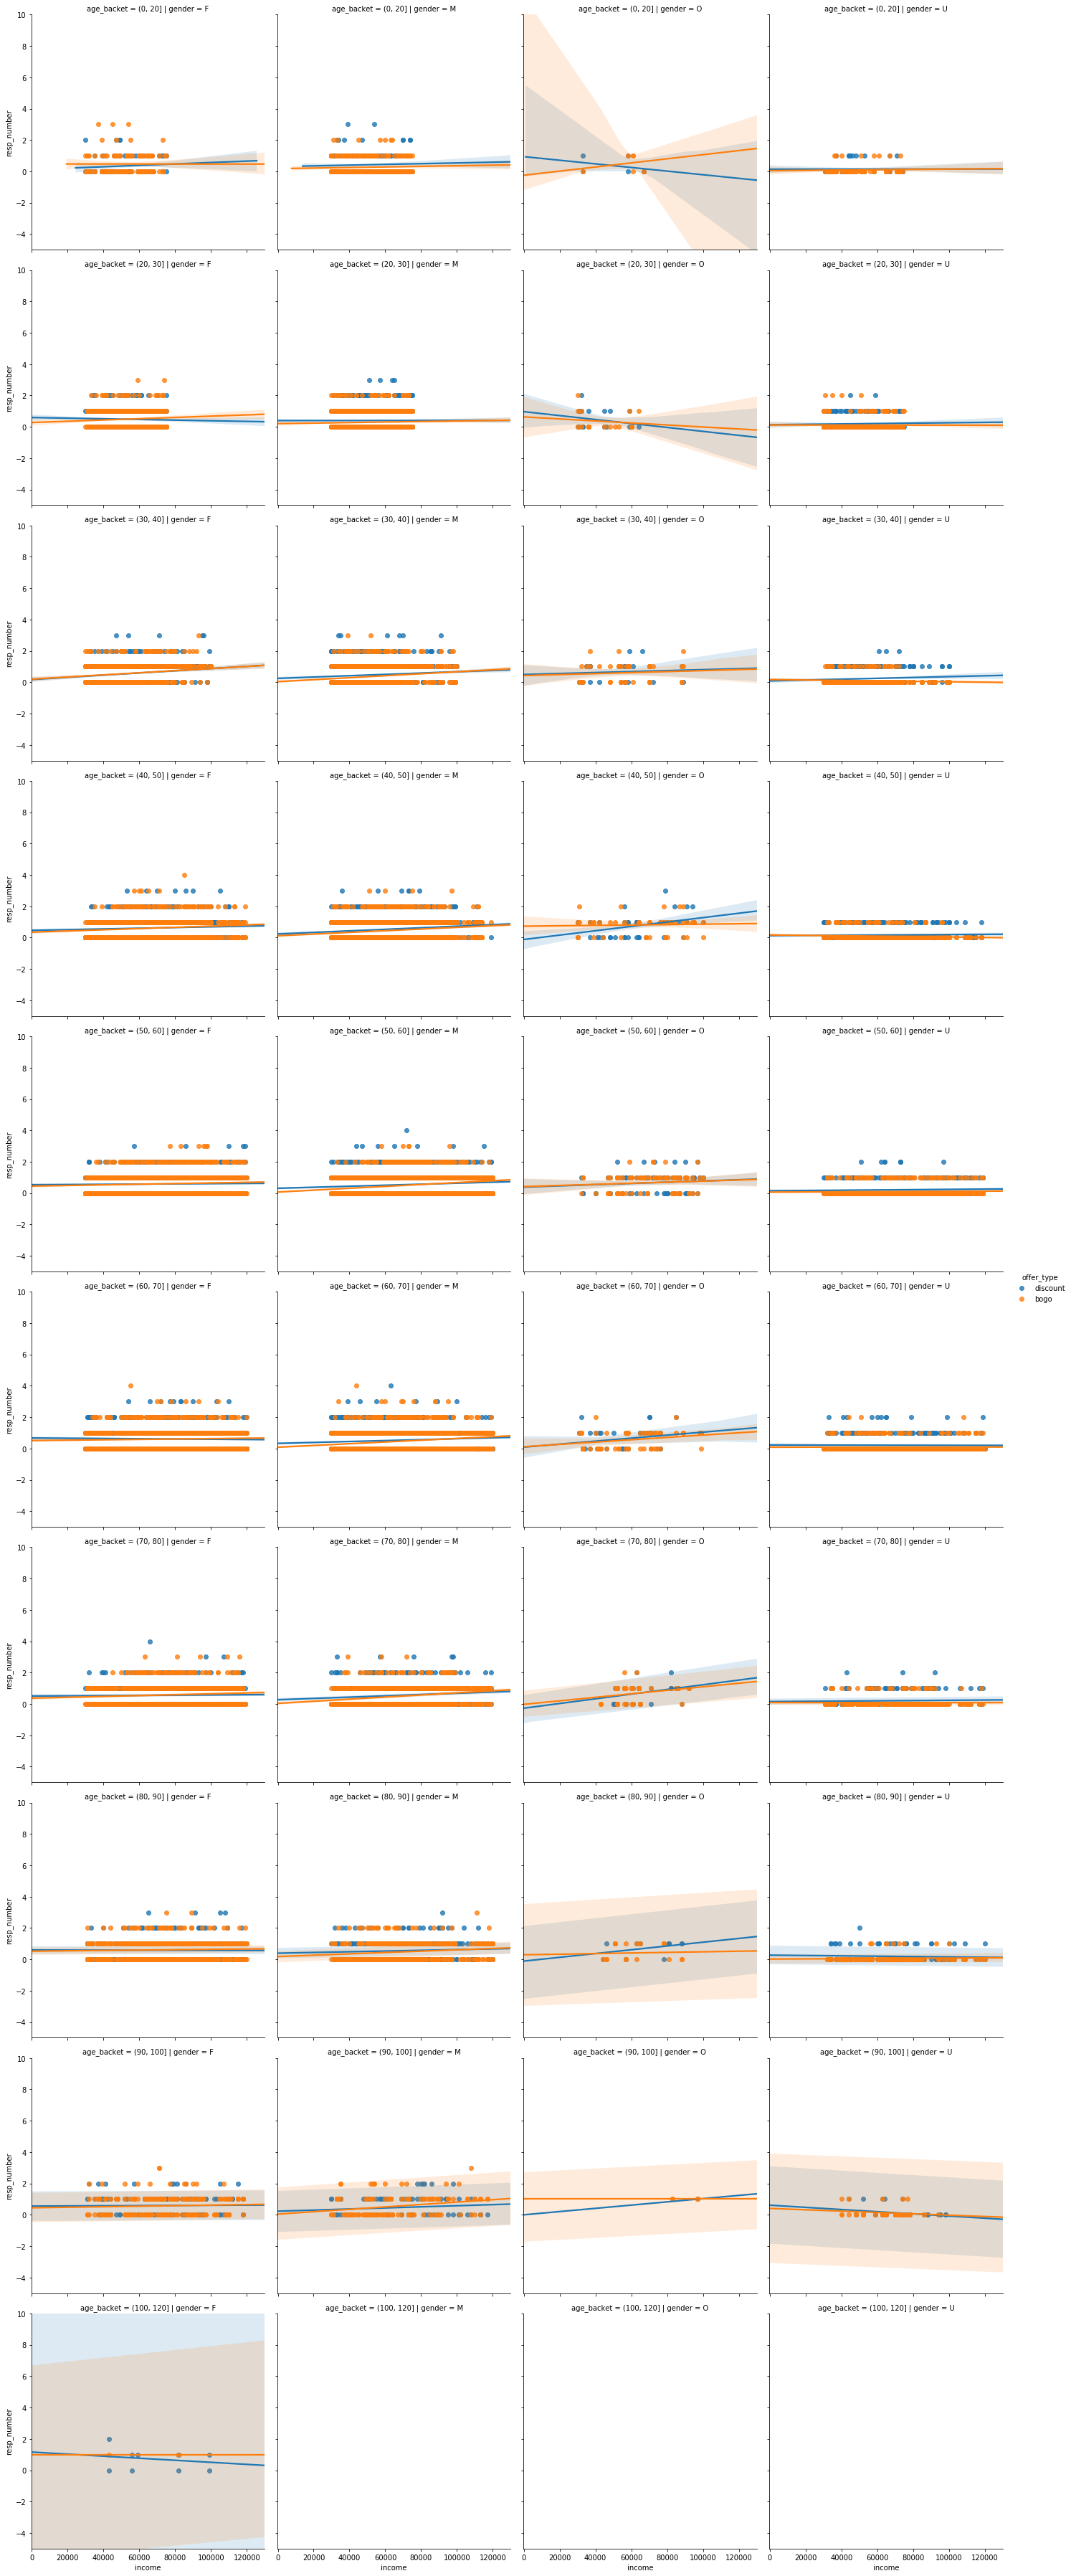

In [79]:
g = sns.lmplot(x="income", y="resp_number", 
               col="gender", row='age_backet', hue='offer_type',
               data=response_merged, height=5, 
               col_order=ordered_genders, row_order=ordered_age_backets);
g.set(xlim=(-200, 130000), ylim=(-5, 10));
plt.savefig("images/response_merged-income_vs_resp_number-grid.png")

**Notes:**

We can see that there is a positive correlation between a customer's income and the number of times they respond to an offer. The relationship is more pronounced among customers between the ages of 30 and 50, whether they are male or female customers, or customers of other genders. In the age group of 50 to 90, the relationship persists among male customers and customers of other genders.

In [80]:
counts_mean_age_backet = create_counts_df(response_merged, ['age_backet', 'profile_id'])

counts_mean_age_backet.head()

,age_backet,profile_id,resp_fields,mean
0,"(0, 20]",42,response,0.0
1,"(0, 20]",42,resp_number,0.0
2,"(0, 20]",42,resp_amount,0.0
3,"(0, 20]",42,resp_reward,0.0
4,"(0, 20]",104,response,0.0


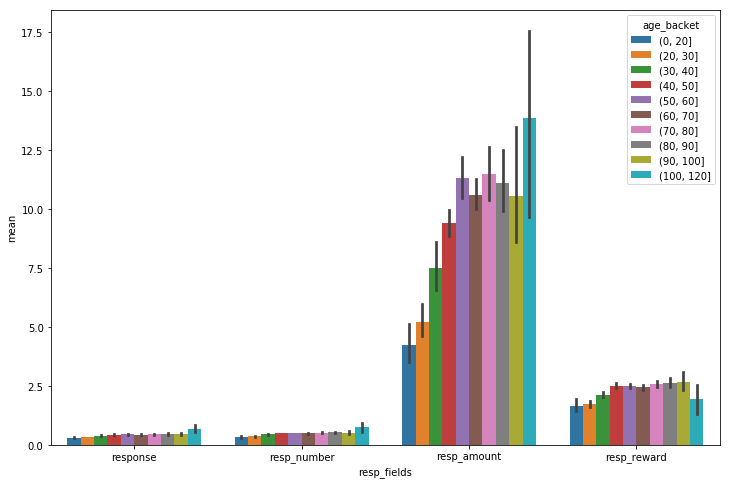

In [81]:
plt.figure(figsize=(12, 8))
sns.barplot(x="resp_fields", y="mean", hue='age_backet', data=counts_mean_age_backet,
            hue_order=ordered_age_backets)
plt.savefig("images/response_merged-counts_mean-resp_fields_vs_mean-hue_age_backet.png")

In [82]:
counts_mean_income_backet = create_counts_df(response_merged, ['income_backet', 'profile_id'])

counts_mean_income_backet.head(8)

,income_backet,profile_id,resp_fields,mean
0,"(0, 30000]",42,response,0.0
1,"(0, 30000]",42,resp_number,0.0
2,"(0, 30000]",42,resp_amount,0.0
3,"(0, 30000]",42,resp_reward,0.0
4,"(0, 30000]",138,response,0.0
5,"(0, 30000]",138,resp_number,0.0
6,"(0, 30000]",138,resp_amount,0.0
7,"(0, 30000]",138,resp_reward,0.0


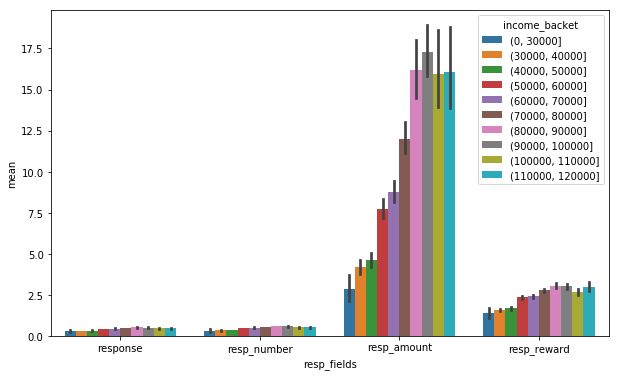

In [83]:
plt.figure(figsize=(10, 6))
sns.barplot(x="resp_fields", y="mean", hue='income_backet', 
            data=counts_mean_income_backet,
            hue_order=ordered_income_backets)
plt.savefig("images/response_merged-counts_mean-resp_fields_vs_mean-hue_income_backet.png")

In [84]:
counts_mean_reg_year = create_counts_df(response_merged, ['reg_year', 'profile_id'])

counts_mean_reg_year.head()

,reg_year,profile_id,resp_fields,mean
0,2013,25,response,1.000
1,2013,25,resp_number,1.500
2,2013,25,resp_amount,29.725
3,2013,25,resp_reward,7.000
4,2013,47,response,0.000


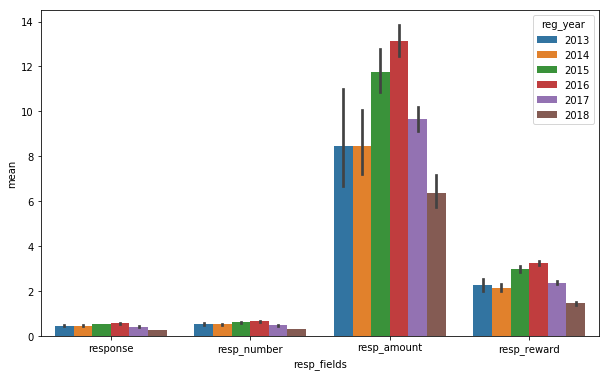

In [85]:
plt.figure(figsize=(10, 6))
sns.barplot(x="resp_fields", y="mean", hue='reg_year', data=counts_mean_reg_year)
plt.savefig("images/response_merged-counts_mean-resp_fields_vs_mean-hue_reg_year.png")

In [86]:
response_merged.groupby("difficulty")['resp_number'].mean()

difficulty
5     0.457399
7     0.693913
10    0.483867
20    0.210700
Name: resp_number, dtype: float64

In [87]:
response_merged.groupby("duration")['resp_number'].mean()

duration
5     0.505162
7     0.450847
10    0.469857
Name: resp_number, dtype: float64

In [88]:
response_merged.groupby("reward")['resp_number'].mean()

reward
2     0.539906
3     0.693913
5     0.374598
10    0.428212
Name: resp_number, dtype: float64

**Notes:**

As for the difficulty, validity period and rewards of offer, there is little  relationship between them and the number of times a customer responds to an offer.

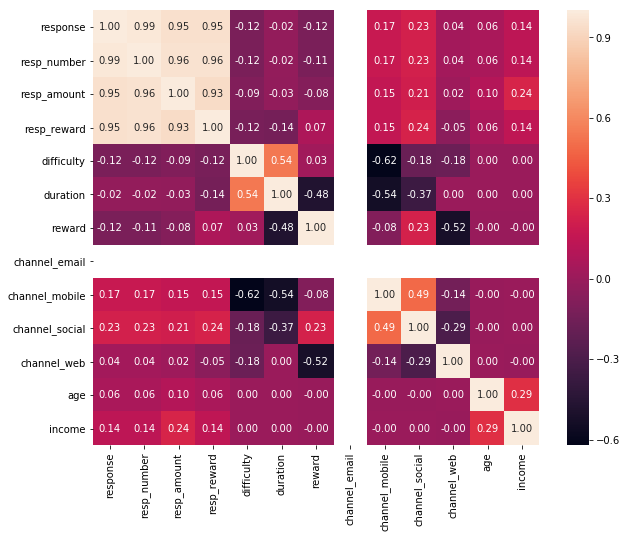

In [89]:
response_merged_corr = response_merged.drop(columns=[
    'profile_id', 'offer_id', 'reg_year', 'reg_month'])

plt.figure(figsize=(10, 8))
sns.heatmap(response_merged_corr.corr(method='spearman'), annot=True, fmt=".2f")
plt.savefig("images/response_merged-corr.png")

**Notes:**
    
On the whole, there is a positive correlation between a customer's income and the amount they pay when they respond to an offer. I also noticed that there was a positive correlation between "channel_social" and customer responses to offer. Does this mean that sending flyers on the side of the road is more attractive to customers to come into the store?

In [90]:
response_merged.groupby('channel_social')[
    'response', 'resp_number', 'resp_amount', 'resp_reward'].mean()

,response,resp_number,resp_amount,resp_reward
channel_social,,,,
0,0.278426,0.300989,6.234197,1.160198
1,0.508396,0.570218,11.357048,2.994687


In [91]:
portfolio_ordered[(portfolio_ordered['offer_type']!='informational') & 
                  (portfolio_ordered['channel_social']==1)]

,ranking,offer_id,offer_type,difficulty,duration,reward,channel_email,channel_mobile,channel_social,channel_web
0,5,1,bogo,10,7,10,1,1,1,0
1,4,2,bogo,10,5,10,1,1,1,1
5,2,6,discount,7,7,3,1,1,1,1
6,1,7,discount,10,10,2,1,1,1,1
8,3,9,bogo,5,5,5,1,1,1,1


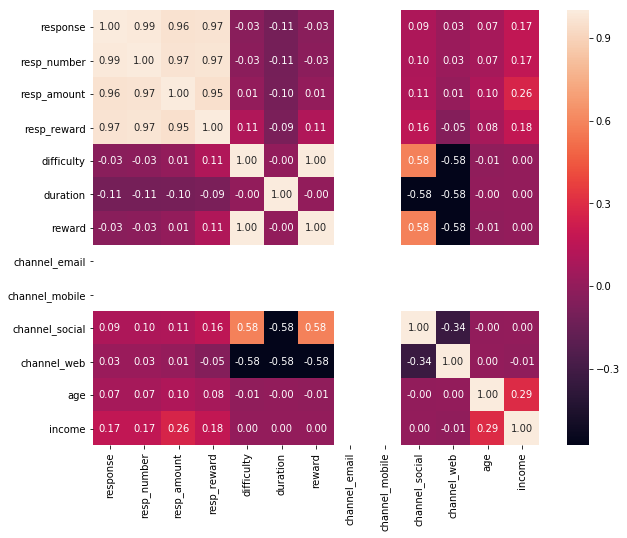

In [92]:
response_merged_corr_bogo = response_merged_corr[
    response_merged_corr['offer_type']=='bogo']

plt.figure(figsize=(10, 8))
sns.heatmap(response_merged_corr_bogo.corr(method='spearman'), annot=True, fmt=".2f")
plt.savefig("images/response_merged-corr-bogo.png")

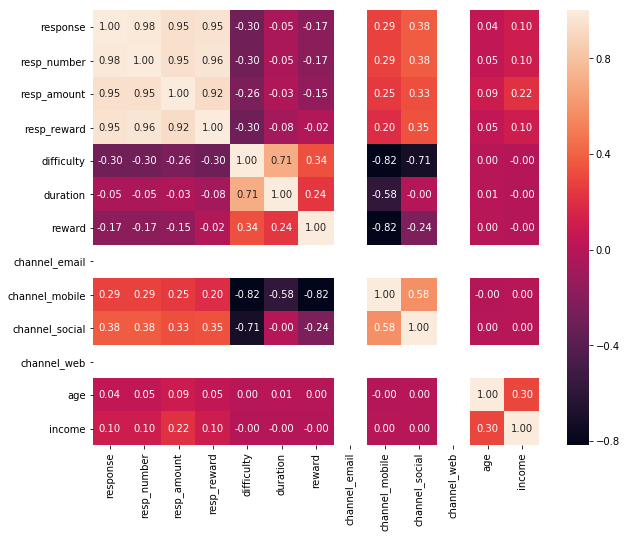

In [93]:
response_merged_corr_discount = response_merged_corr[
    response_merged_corr['offer_type']=='discount']

plt.figure(figsize=(10, 8))
sns.heatmap(response_merged_corr_discount.corr(method='spearman'), annot=True, fmt=".2f")
plt.savefig("images/response_merged-corr-discount.png")

**Notes:**

If we only look at discount offer, we will find that there is a more obvious negative correlation relationship between the various counts of customer's response for offer and the difficulty of offer. That is, the higher the consumption threshold for discount offer, the less customers respond.

In [94]:
# Aggregates the merged response. 
# Create a data frame centered only on profile_id.
response_agg = cbn.aggregate_merged_response(response_merged, profile_cleaned)

print(response_agg.shape)
print(response_agg.columns)

print("The number of invalid values in the data frame is {}."
      .format(response_agg.isnull().sum().sum()))

num_no_response = response_agg[
    (response_agg['response_sum_bogo']==0) &
    (response_agg['response_sum_discount']==0)]['profile_id'].count()

print("The number of customers who did not respond to any offer is {}."
      .format(num_no_response))

response_agg.head()

(16928, 22)
Index(['profile_id', 'response_sum_bogo', 'resp_number_mean_bogo',
       'resp_amount_mean_bogo', 'resp_reward_mean_bogo',
       'difficulty_mean_bogo', 'duration_mean_bogo', 'reward_mean_bogo',
       'response_sum_discount', 'resp_number_mean_discount',
       'resp_amount_mean_discount', 'resp_reward_mean_discount',
       'difficulty_mean_discount', 'duration_mean_discount',
       'reward_mean_discount', 'gender', 'age', 'age_backet', 'income',
       'income_backet', 'reg_year', 'reg_month'],
      dtype='object')
The number of invalid values in the data frame is 0.
The number of customers who did not respond to any offer is 5201.


,profile_id,response_sum_bogo,resp_number_mean_bogo,resp_amount_mean_bogo,resp_reward_mean_bogo,difficulty_mean_bogo,duration_mean_bogo,reward_mean_bogo,response_sum_discount,resp_number_mean_discount,...,difficulty_mean_discount,duration_mean_discount,reward_mean_discount,gender,age,age_backet,income,income_backet,reg_year,reg_month
0,2,0.0,0.000000,0.00,0.0,5.000000,7.000000,5.000000,0.0,0.0,...,0.0,0.0,0.0,F,55.0,"(50, 60]",112000.0,"(110000, 120000]",2017,7
1,3,0.0,0.000000,0.00,0.0,5.000000,7.000000,5.000000,0.0,0.0,...,0.0,0.0,0.0,U,75.0,"(70, 80]",100000.0,"(90000, 100000]",2018,7
2,4,2.0,0.666667,13.87,5.0,6.666667,6.333333,6.666667,0.0,0.0,...,0.0,0.0,0.0,F,75.0,"(70, 80]",100000.0,"(90000, 100000]",2017,5
3,6,1.0,1.000000,18.42,5.0,5.000000,7.000000,5.000000,1.0,0.5,...,10.0,8.5,2.0,M,68.0,"(60, 70]",70000.0,"(60000, 70000]",2018,4
4,7,0.0,0.000000,0.00,0.0,10.000000,5.000000,10.000000,0.0,0.0,...,10.0,8.5,2.0,U,65.0,"(60, 70]",53000.0,"(50000, 60000]",2017,9


In [95]:
response_agg.groupby(by=['gender'])[
    'response_sum_bogo', 'response_sum_discount', 
    'resp_number_mean_bogo', 'resp_number_mean_discount',
    'resp_amount_mean_bogo', 'resp_amount_mean_discount', 
    'resp_reward_mean_bogo', 'resp_reward_mean_discount'].mean()

,response_sum_bogo,response_sum_discount,resp_number_mean_bogo,resp_number_mean_discount,resp_amount_mean_bogo,resp_amount_mean_discount,resp_reward_mean_bogo,resp_reward_mean_discount
gender,,,,,,,,
F,0.783877,0.773226,0.528429,0.529193,12.294062,11.547046,4.023772,1.423904
M,0.574675,0.679408,0.384458,0.452081,8.019164,7.879559,2.814645,1.206489
O,0.824645,0.843602,0.564376,0.599526,9.600371,11.952034,4.103476,1.691943
U,0.138170,0.286506,0.085182,0.176602,1.150304,1.643080,0.492529,0.436075


**Notes:**

On the whole, female customers have a similar attitude towards both types of offer, but they spend significantly more on responding to BOGO offer, and of course, they get more rewards as a result. Male customers have a clear preference for discount offer, but they spend a little more on their response to BOGO offer, as well as on the rewards they receive. 

The customers of other genders spend more on responding to discount offers but receive fewer rewards. 

## 4. Modeling

In [96]:
# For model
# Separate the column named gender.
gender_type_df = pd.get_dummies(response_agg['gender'],
                                prefix='gender',
                                prefix_sep='_')

response_model = response_agg.join(gender_type_df)

# Drop useless columns.
response_model = response_model.drop(columns=[
    'gender', 'age_backet', 'income_backet'])

# Drop columns that are not relevant.
# The reason why I exclude the year of membership registration is that I think it has poor compatibility. 
# The value of this column in the new data will most likely not exist in the existing data.
response_model = response_model.drop(columns=['profile_id', 'reg_year'])

print(response_model.shape)
print(response_model.columns)

(16928, 21)
Index(['response_sum_bogo', 'resp_number_mean_bogo', 'resp_amount_mean_bogo',
       'resp_reward_mean_bogo', 'difficulty_mean_bogo', 'duration_mean_bogo',
       'reward_mean_bogo', 'response_sum_discount',
       'resp_number_mean_discount', 'resp_amount_mean_discount',
       'resp_reward_mean_discount', 'difficulty_mean_discount',
       'duration_mean_discount', 'reward_mean_discount', 'age', 'income',
       'reg_month', 'gender_F', 'gender_M', 'gender_O', 'gender_U'],
      dtype='object')


In [97]:
from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

X = response_model

scores1 = []
scores2 = []
numbers = [n for n in range(2, 15)]

# RobustScaler is insensitive to outliers in the data. 
# RobustScaler allows the model to score significantly higher when the number of clusters is small. 
# However, I finally chose MinMaxScaler, because too few clusters lead to poor clustering results.
scaler = MinMaxScaler() 
scaler.fit(X) 
X_scaled = scaler.transform(X)

start_time = time.time()

for n in numbers:
    kmeans = KMeans(n_clusters=n, random_state=103)
    model = kmeans.fit(X_scaled)
    score1 = abs(model.score(X_scaled))
    scores1.append(score1)
    labels = model.labels_
    score2 = silhouette_score(X_scaled, labels, metric='manhattan')
    scores2.append(score2)
    
end_time = time.time()
print('The time spent training models and evaluation: {}s'.\
      format(end_time - start_time))

/Users/haolin/.pyenv/versions/anaconda3-5.3.0/envs/dsnd-capstone/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


The time spent training models and evaluation: 79.6926212310791s


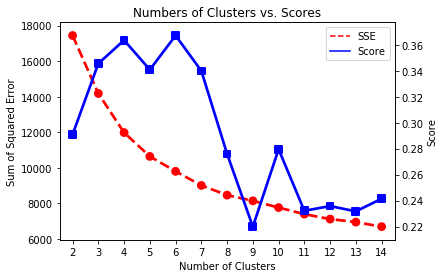

In [98]:
# draw a figure for the visualization of score values
from matplotlib.lines import Line2D

f, ax1 = plt.subplots()
ax1.set_ylabel('Sum of Squared Error')
ax1.set_xlabel('Number of Clusters')
ax1.set_title('Numbers of Clusters vs. Scores')
g1 = sns.pointplot(x=numbers, y=scores1, 
                   markers='o', linestyles='--', 
                   color='r', ax=ax1)
 
ax2 = ax1.twinx()
ax2.set_ylabel('Score')
g2 = sns.pointplot(x=numbers, y=scores2, 
                   markers=',', linestyles='-', 
                   color='b', ax=ax2)

sse_patch = Line2D([], [], color='r', label='SSE')
sse_patch.set_linestyle('--')
score_patch = Line2D([], [], color='b', label='Score')
score_patch.set_linestyle('-')
plt.legend(handles=[sse_patch, score_patch])
plt.savefig("images/clusters-numbers_vs_scores.png")
plt.show()

**Notes:**

The SSE is defined as the sum of the squared distance between each member of the cluster and its centroid.

I will choose the number of clusters with higher score and lower SSE. This is often a trade-off.

**Notes:**
    
I chose agglomerative clustering as the final clustering algorithm. Agglomerative clustering is superior to k-means clustering. Although the former is slower in speed, the clustering effect is much better.

I choose the silhouette coefficient as the evaluation method of the clustering model, because we do not have the real clustering label. The silhouette coefficient will be compared according to the similarity degree of elements within the cluster and the similarity degree of elements between the clusters. In general, the higher the contour coefficient, the better the clustering effect.

I used the Manhattan algorithm to compute the distance between vectors. Compared with Euclidean algorithm, Manhattan algorithm is better.

Reference: https://scikit-learn.org/stable/modules/clustering.html

In [99]:
selected_number = 6
cluster_col_name = 'cluster_' + str(selected_number)

clustering_model = cluster.AgglomerativeClustering(
    n_clusters=selected_number, affinity='manhattan', linkage='average')

start_time = time.time()

labels = clustering_model.fit_predict(X_scaled)

end_time = time.time()
print('The time spent training model and prediction: {}s'.\
      format(end_time - start_time))

print("Score: {}\n".format(silhouette_score(X_scaled, labels, metric='manhattan')))


The time spent training model and prediction: 12.640151023864746s
Score: 0.3778625521056108



In [100]:
response_agg.insert(0, cluster_col_name, labels)

print(response_agg[cluster_col_name].value_counts())
print(response_agg[cluster_col_name].value_counts(normalize=True))

response_agg.head()

1    6486
0    4718
3    1936
5    1910
2    1722
4     156
Name: cluster_6, dtype: int64
1    0.383152
0    0.278710
3    0.114367
5    0.112831
2    0.101725
4    0.009216
Name: cluster_6, dtype: float64


,cluster_6,profile_id,response_sum_bogo,resp_number_mean_bogo,resp_amount_mean_bogo,resp_reward_mean_bogo,difficulty_mean_bogo,duration_mean_bogo,reward_mean_bogo,response_sum_discount,...,difficulty_mean_discount,duration_mean_discount,reward_mean_discount,gender,age,age_backet,income,income_backet,reg_year,reg_month
0,2,2,0.0,0.000000,0.00,0.0,5.000000,7.000000,5.000000,0.0,...,0.0,0.0,0.0,F,55.0,"(50, 60]",112000.0,"(110000, 120000]",2017,7
1,5,3,0.0,0.000000,0.00,0.0,5.000000,7.000000,5.000000,0.0,...,0.0,0.0,0.0,U,75.0,"(70, 80]",100000.0,"(90000, 100000]",2018,7
2,2,4,2.0,0.666667,13.87,5.0,6.666667,6.333333,6.666667,0.0,...,0.0,0.0,0.0,F,75.0,"(70, 80]",100000.0,"(90000, 100000]",2017,5
3,1,6,1.0,1.000000,18.42,5.0,5.000000,7.000000,5.000000,1.0,...,10.0,8.5,2.0,M,68.0,"(60, 70]",70000.0,"(60000, 70000]",2018,4
4,5,7,0.0,0.000000,0.00,0.0,10.000000,5.000000,10.000000,0.0,...,10.0,8.5,2.0,U,65.0,"(60, 70]",53000.0,"(50000, 60000]",2017,9


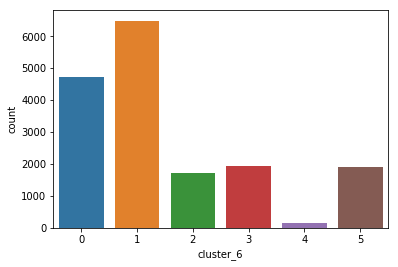

In [120]:
sns.countplot(x=cluster_col_name, data=response_agg)
plt.savefig("images/response_agg-cluster-counts.png")

**Notes:**

Clustering 1 has the largest number of customers, followed by clustering 0 and clustering 3. The number of customers in clustering 3, clustering 5 and clustering 2 is not much different. The number of customers in cluster 4 is significantly smaller (only 156). 

In [101]:
response_agg.groupby(by=cluster_col_name)[
    'response_sum_bogo', 'response_sum_discount',
    'resp_number_mean_bogo', 'resp_number_mean_discount',
    'resp_amount_mean_bogo', 'resp_amount_mean_discount',
    'resp_reward_mean_bogo', 'resp_reward_mean_discount',
    'difficulty_mean_bogo', 'difficulty_mean_discount',
    'duration_mean_bogo', 'duration_mean_discount',
    'reward_mean_bogo', 'reward_mean_discount'
].mean()

,response_sum_bogo,response_sum_discount,resp_number_mean_bogo,resp_number_mean_discount,resp_amount_mean_bogo,resp_amount_mean_discount,resp_reward_mean_bogo,resp_reward_mean_discount,difficulty_mean_bogo,difficulty_mean_discount,duration_mean_bogo,duration_mean_discount,reward_mean_bogo,reward_mean_discount
cluster_6,,,,,,,,,,,,,,
0,0.853116,0.831496,0.590134,0.585294,13.568962,12.828501,4.490603,1.577505,7.489049,11.816236,5.998587,8.505723,7.489049,3.015508
1,0.618101,0.746223,0.425442,0.505512,9.048794,8.854792,3.101424,1.349137,7.528908,11.746929,5.997276,8.509405,7.528908,3.003058
2,0.947154,0.000000,0.548248,0.000000,11.783889,0.000000,4.143922,0.000000,7.535327,0.000000,6.030585,0.000000,7.535327,0.000000
3,0.000000,0.945764,0.000000,0.560391,0.000000,10.298047,0.000000,1.488507,0.000000,11.762268,0.000000,8.512138,0.000000,3.006543
4,0.955128,0.916667,0.673077,0.689103,11.651154,13.909915,4.925214,1.952991,7.232906,11.516026,6.130342,8.403846,7.232906,3.017094
5,0.156545,0.272775,0.096510,0.170593,1.303276,1.605961,0.558028,0.421990,7.496073,10.097339,5.994939,7.323822,7.496073,2.576440


**Explained as follows:**

- Cluster 0: The customers have a better response to both offer (response_sum:0.8+). They don't have a pronounced preference for either offer.
- Cluster 1: This part of the customer response to both offer is OK, not high or low (response_sum:0.6-0.75).
- Cluster 2: This part of the customer is not interested in discount offer at all, but the response to another offer is excellent (response_sum:0.9+).
- Cluster 3: This part of the customer is not interested in BOGO offer at all, but the response to another offer is excellent (response_sum:0.9+).
- Cluster 4: This part of the customer has an excellent response to both offer (response_sum:0.9+). They spend more money on the discount offers. And the number of offer they receive should be small.
- Cluster 5: The customers have an inadequate response to both offer (response_sum: 0.15-0.3).

**Notes:**

The value of the response_sum column indicates how many offer a customer has responded to in total. 

The value of the resp_number_mean column indicates how many times a customer has completed an offer that he received on average. 

Therefore, from these two parts of the value, we can infer the general situation of their response to the offer.

In [102]:
response_cluster_groups = response_agg.groupby(by=[cluster_col_name, 'profile_id'])

response_clusters = response_cluster_groups.mean().reset_index()

response_clusters.head()

,cluster_6,profile_id,response_sum_bogo,resp_number_mean_bogo,resp_amount_mean_bogo,resp_reward_mean_bogo,difficulty_mean_bogo,duration_mean_bogo,reward_mean_bogo,response_sum_discount,resp_number_mean_discount,resp_amount_mean_discount,resp_reward_mean_discount,difficulty_mean_discount,duration_mean_discount,reward_mean_discount,age,income,reg_year,reg_month
0,0,14,2.0,0.666667,8.296667,5.0,8.333333,5.666667,8.333333,0.0,0.00,0.0000,0.0,20.00,10.0,5.0,61.0,57000.0,2017,9
1,0,23,0.0,0.000000,0.000000,0.0,10.000000,5.000000,10.000000,1.0,1.00,13.3200,2.0,10.00,10.0,2.0,78.0,71000.0,2017,6
2,0,26,1.0,0.500000,14.240000,5.0,7.500000,6.000000,7.500000,2.0,1.50,41.4700,6.0,15.00,8.5,3.5,56.0,88000.0,2018,4
3,0,28,0.0,0.000000,0.000000,0.0,5.000000,7.000000,5.000000,1.0,0.25,0.7675,0.5,11.75,8.5,3.0,33.0,52000.0,2017,9
4,0,29,0.0,0.000000,0.000000,0.0,10.000000,5.000000,10.000000,0.0,0.00,0.0000,0.0,20.00,10.0,5.0,46.0,59000.0,2017,9


**Notes:**

From the following picture, we can see more easily the response of different customer groups to the two offer.

By comparing the values of response_sum columns between different clusters, we can clearly see the preferences of customers in these clusters for both offer.

In [103]:
response_agg.groupby(cluster_col_name)[
    'response_sum_bogo', 'response_sum_discount'].mean().reset_index()

,cluster_6,response_sum_bogo,response_sum_discount
0,0,0.853116,0.831496
1,1,0.618101,0.746223
2,2,0.947154,0.000000
3,3,0.000000,0.945764
4,4,0.955128,0.916667
5,5,0.156545,0.272775


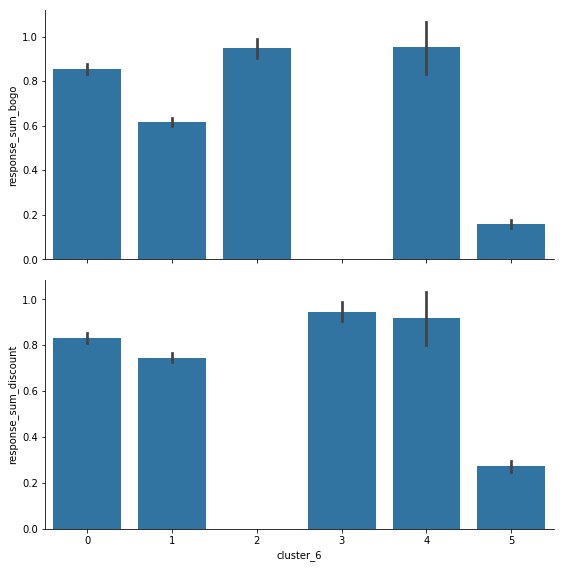

In [104]:
g = sns.PairGrid(response_clusters, 
                 y_vars=['response_sum_bogo', 'response_sum_discount'], 
                 x_vars=cluster_col_name, aspect=2, height=4)
g.map(sns.barplot)
g.savefig("images/response_clusters-response_sums.png")

In [105]:
response_agg.groupby(cluster_col_name)[
    'resp_number_mean_bogo', 'resp_number_mean_discount'].mean().reset_index()

,cluster_6,resp_number_mean_bogo,resp_number_mean_discount
0,0,0.590134,0.585294
1,1,0.425442,0.505512
2,2,0.548248,0.000000
3,3,0.000000,0.560391
4,4,0.673077,0.689103
5,5,0.096510,0.170593


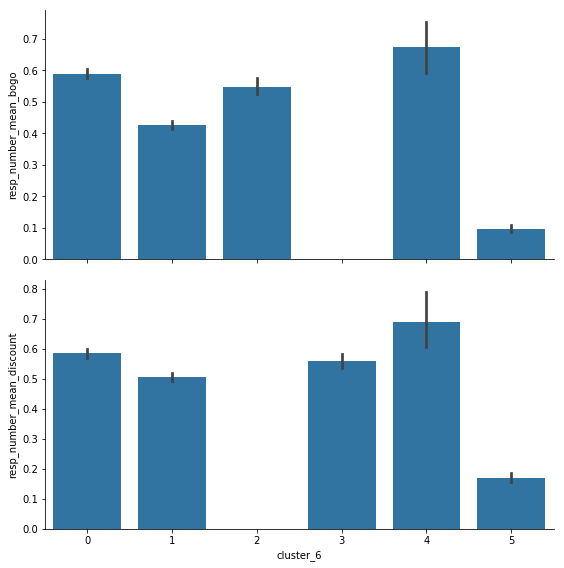

In [106]:
g = sns.PairGrid(response_clusters, 
                 y_vars=['resp_number_mean_bogo', 'resp_number_mean_discount'], 
                 x_vars=cluster_col_name, aspect=2, height=4)
g.map(sns.barplot)
g.savefig("images/response_clusters-resp_number_mean.png")

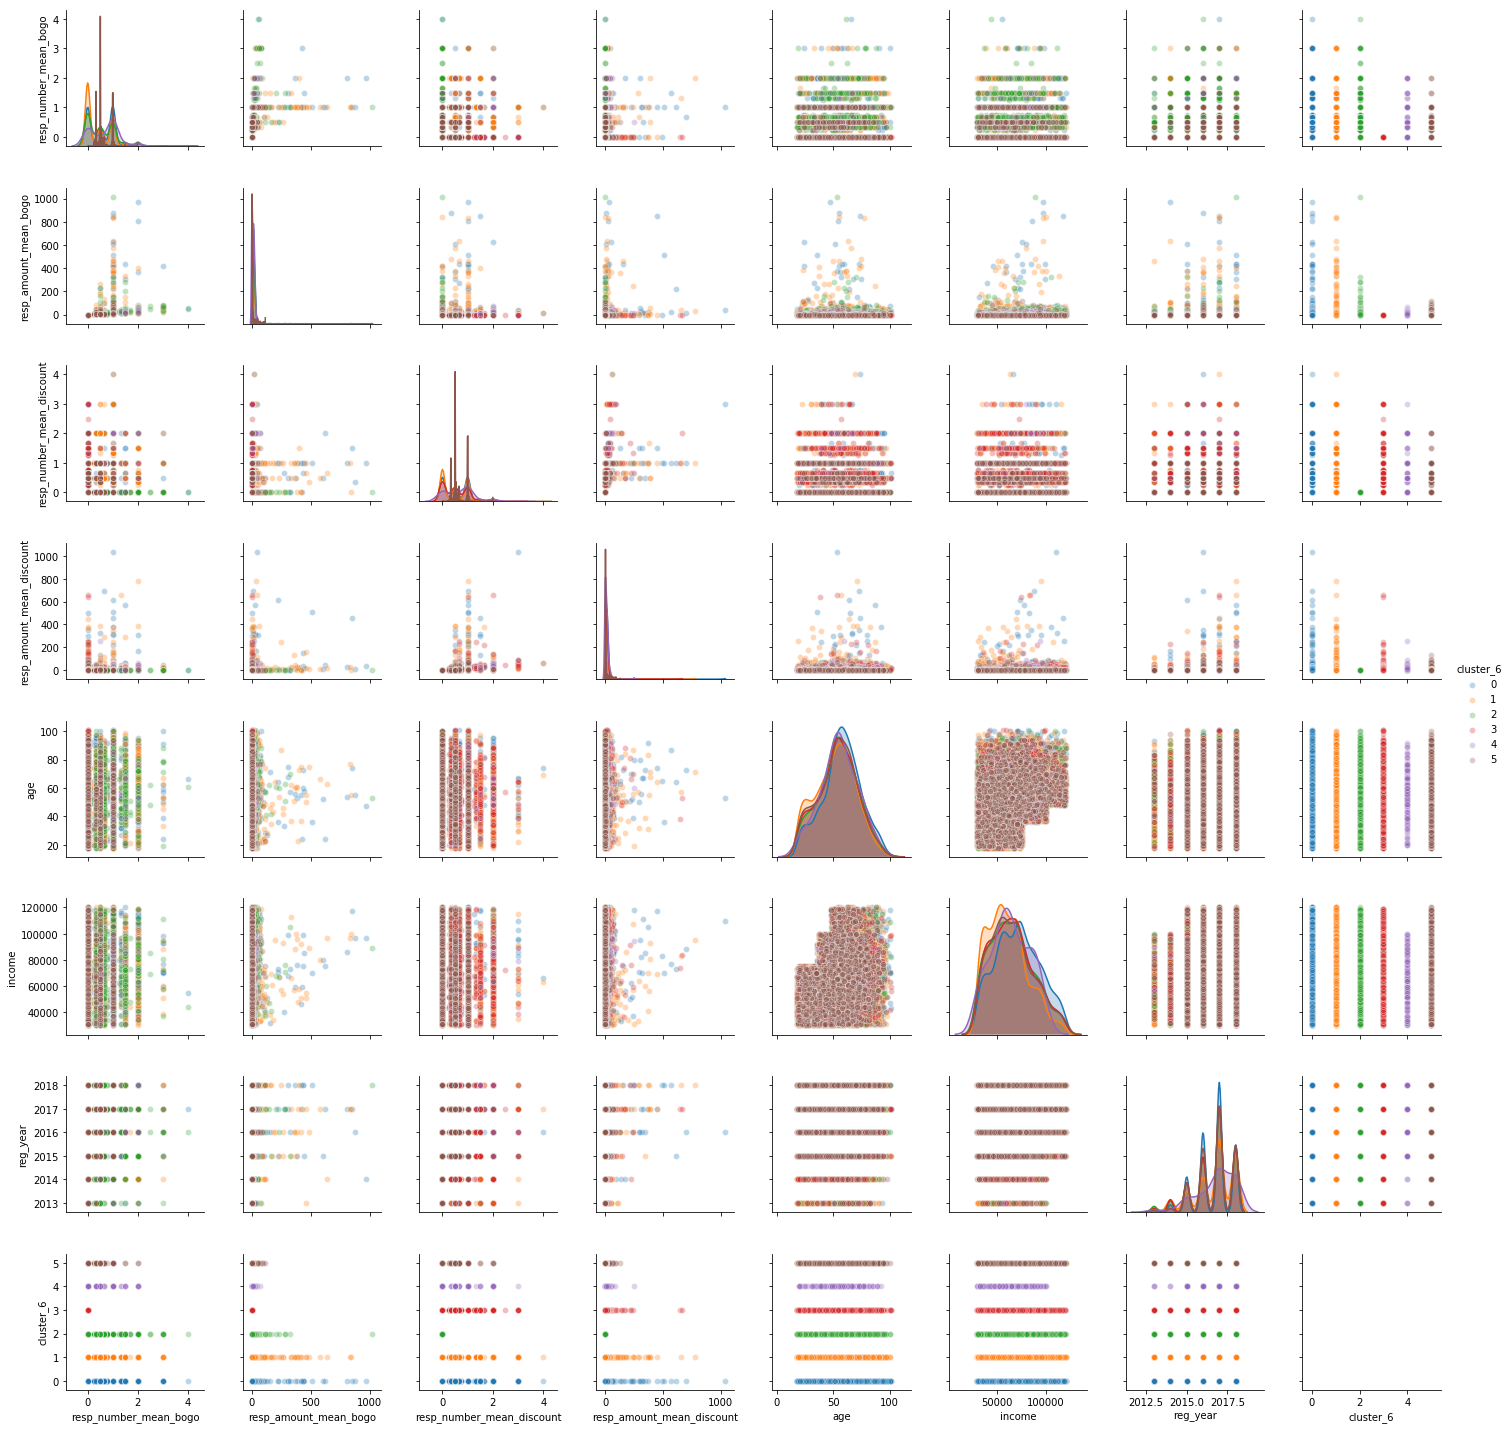

In [108]:
col_names_pair = ['resp_number_mean_bogo', 'resp_amount_mean_bogo', 
                  'resp_number_mean_discount', 'resp_amount_mean_discount',
                  'gender', 'age', 'income', 'reg_year',
                  cluster_col_name]

g = sns.pairplot(response_agg[col_names_pair], hue=cluster_col_name,
                 kind='scatter', diag_kind='auto', plot_kws={'alpha': 0.3});
g.savefig("images/response_agg-pair.png")

In [109]:
response_agg.groupby(by=[cluster_col_name, 'gender'])[
    'profile_id'].count().reset_index()

,cluster_6,gender,profile_id
0,0,F,4718
1,1,M,6486
2,2,F,683
3,2,M,1013
4,2,O,26
5,3,F,702
6,3,M,951
7,3,O,29
8,3,U,254
9,4,O,156


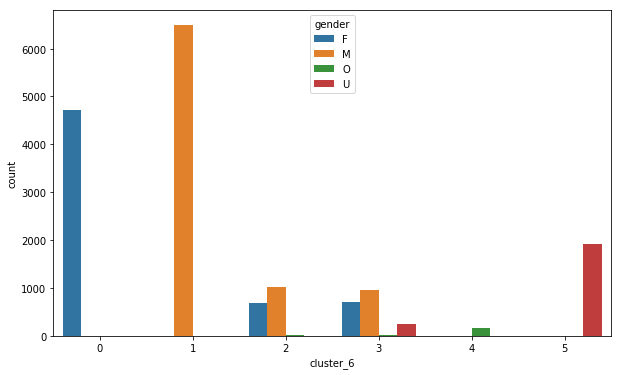

In [110]:
plt.figure(figsize=(10, 6))
g = sns.countplot(x=cluster_col_name, hue='gender', data=response_agg,
                  hue_order=ordered_genders)
plt.savefig("images/response_agg-genders.png")

**Notes:**

The ratio of men to women in cluster 2 is not too large, as is clustering 3.

Clustering 0 and Clustering 1 are impressive, with only female customers in the former and only male customers in the latter. In the light of the previous explanations of each cluster, it is easier for female customers to respond to offer, while male customers perform mostly in general terms.

The number of customers in cluster 4 is small, and the value of gender is "O" (Other). This part of the customer's response to the offer is excellent, they may not want to expose the gender.

Many customers who belong to cluster 5 do not fill in valid gender value, and their response to offer is inadequate. From this point of view, I don't think they are loyal customers of Starbucks.

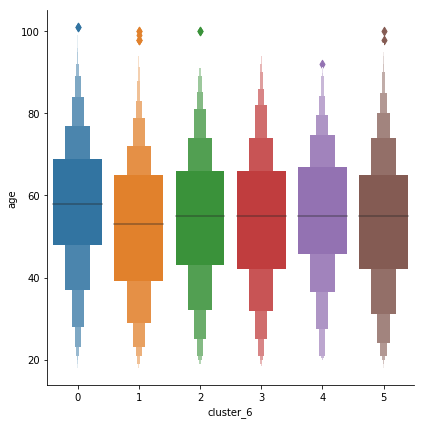

In [111]:
g = sns.catplot(x=cluster_col_name, y='age', data=response_agg,
                kind='boxen', height=6)

g.savefig("images/response_agg-ages.png")

**Notes:**

Then look at the age distribution of customers in different clustering. As far as I saw, these distributions are not much different. We can also infer from this that the age of the customer has little to do with their response to the offer.

Of course, we can still tell the difference in the median age of different clustering customers. For example, cluster 1 contains the lowest median age for customers. They are all men, and their response to both offers is not too bad (response_sum:0.6-0.75). And, clustering 0, in which the median age of the customer is higher, they are all women, and they have a better response to both types of the offer (response_sum: 0.8+).

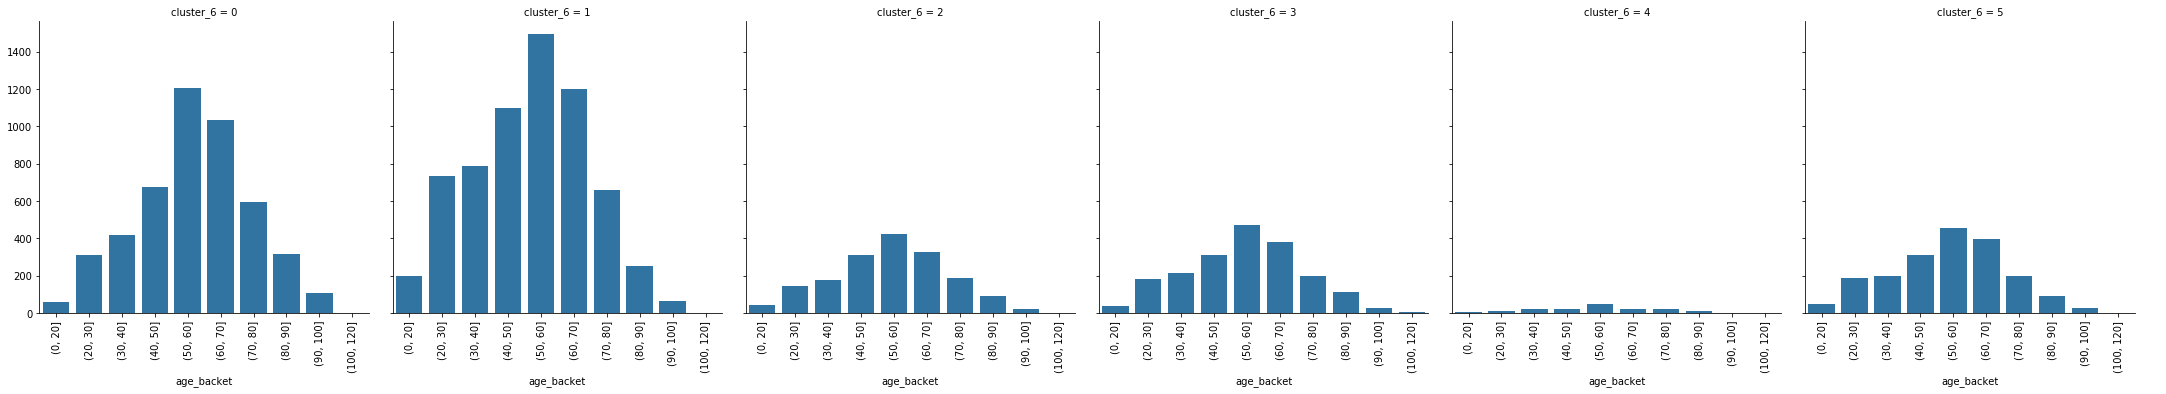

In [112]:
g = sns.FacetGrid(response_agg, col=cluster_col_name, 
                  height=5)
g = g.map(sns.countplot, 'age_backet', order=ordered_age_backets).add_legend()
_ = [plt.setp(ax.get_xticklabels(), rotation=90) for ax in g.axes.flat]

g.savefig("images/response_agg-age_backets.png")

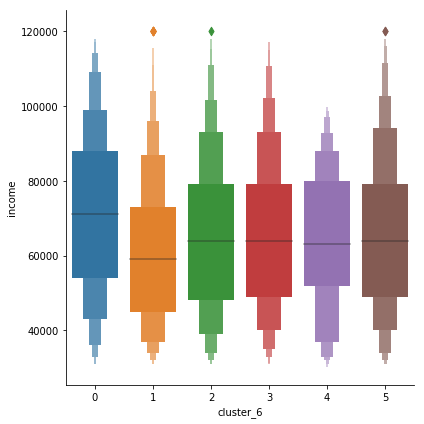

In [113]:
g = sns.catplot(x=cluster_col_name, y='income', data=response_agg,
                kind='boxen', height=6)

g.savefig("images/response_agg-incomes.png")

**Notes:**

The picture above depicts the income distribution of customers in different clustering. The customers in cluster 0 have the highest incomes, and they are all female customers. And the customers in cluster 1 have the lowest income, and they are all male customers. The income levels of customers in other aggregates are not much different. 

From this, the reason why customers in clustering 1 are less responsive to offer may be that they are younger and have low incomes. However, I think there is still hope that this part of the customer will become a mainstay in the future. Starbucks should follow them further.

The customers in cluster 0 and cluster 4 should be the focus of Starbucks. Starbucks should be able to get more from them.

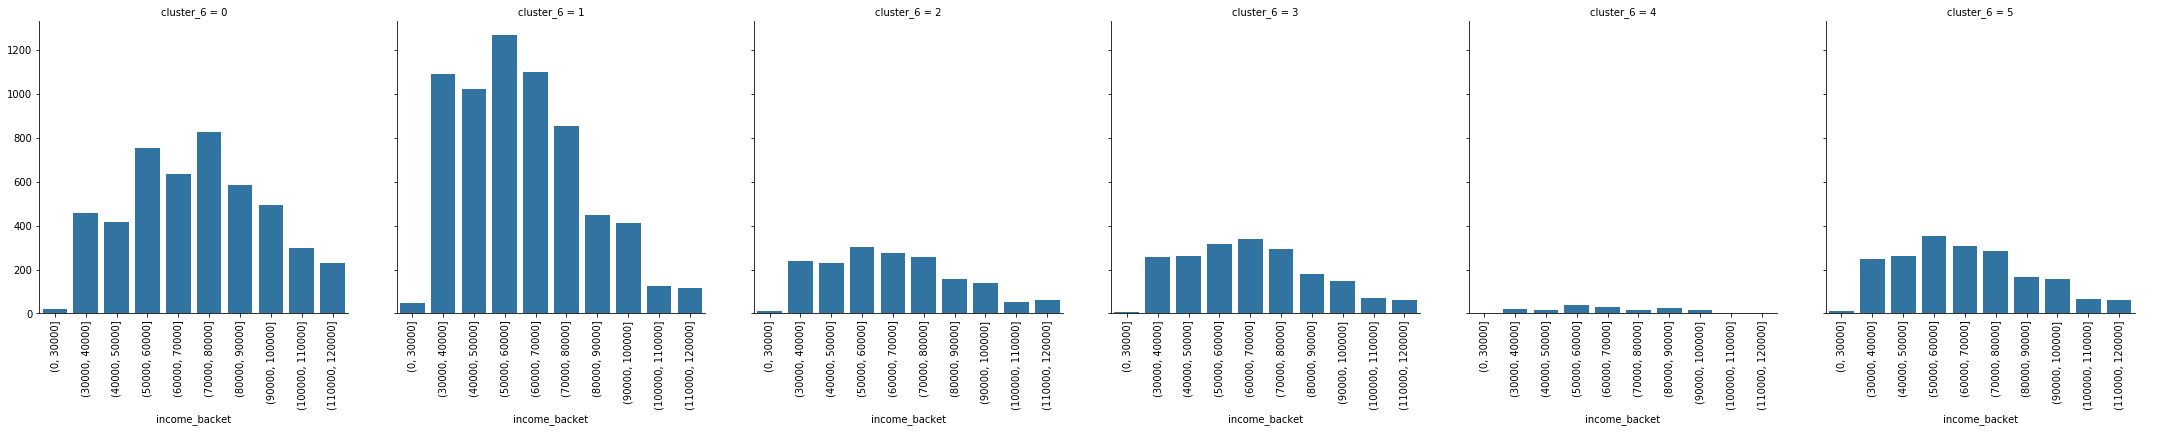

In [114]:
g = sns.FacetGrid(response_agg, col=cluster_col_name, 
                  height=5)
g = g.map(sns.countplot, 'income_backet', order=ordered_income_backets).add_legend()
_ = [plt.setp(ax.get_xticklabels(), rotation=90) for ax in g.axes.flat]

g.savefig("images/response_agg-income_backets.png")

## 5. Conclusion

There are a total of 10 offer in the data. BOGO offer and discount offer each have 4, and the informational offer has 2. The difficulty and reward of the informational offer are 0. The reward for BOGO offer is higher because they have a discount equivalent to 50%.

Among these Starbucks customers, there is the largest number of male customers, followed by female customers. There are also some unknown gender customers, as well as a small number of other genders customers. Overall, female customers have the highest age and income, while male customers are the lowest in both. Also, there is a positive correlation between the customer's age and income. Middle-aged and elderly customers tend to have higher incomes. In turn, customers with higher incomes are usually older.

There are four types of events in the data, namely: "offer Received", "offer viewed", "offer completed" and "transaction". The relationship between the first three types of events is relatively strong. Customers will receive an offer first, some of them will view the offer, and finally, fewer customers will respond to the offer. There will be a delay in the occurrence time between these three types of events. Also, these events conform to the funnel model in quantitative terms.

It is worth noting that even if there is an event record of the "offer completed" type of a customer and an offer in the original data, it does not mean that the customer responded validly to the offer. Because he may have just happened to finish the offer, he may not have looked at the offer at all. The criterion for a customer to respond validly to an offer should be that in transcript there are records of events of "offer received", "offer viewed" and "offer completed", respectively, and must be a record corresponding to the customer and the offer.

It is also important to note that in my current study, I was only able to say the preference of Starbucks customers for BOGO offer and discount offer. Because I couldn't find the customer's response to informational offer in the original data.

---------
Overall, the ratio of customers responding to BOGO offer to discount offer is not the same. The rate of customers responding to discount offer is significantly larger. Besides, some customers will respond to the same offer multiple times. The discount offer is still better in this respect. However, judging by the ranking of these offer for customer response ratios, I have not found a law that is directly related to the characteristics of the offer.

The average consumption amount for female customers is the highest. Surprisingly, the number of customers of other genders, although small, has performed well in this area and is in second place. And for the average of responses, the average number of responses per offer and the average of rewards, this part of the customer's performance even ranked first. The worst performers are customers of unknown gender. 

There is a positive correlation between the customer's income and the number of times they respond to the offer. This relationship is particularly pronounced among male customers. And there is a relationship between customers' income and the amount they pay when they respond to an offer. As for the difficulty, duration, and reward of the offer, there is little relationship between them and the number of times customers respond to an offer.

However, if we only look at the discount offer, we will find that there is a more apparent negative correlation relationship between the various counts about customer response and the difficulty of the offer. That is, the higher the consumption threshold for discount offer, the fewer customers respond.

On the whole, female customers have a similar attitude towards both types of offer, but they spend significantly more on responding to BOGO offer, and they get more rewards as a result. Male customers have a clear preference for discount offer, but they spend a little more on their response to BOGO offer, as well as on the rewards they receive. Customers of other genders are slightly more motivated to respond to discount offer, and they spend significantly more on responding to such offer, but receive fewer rewards.

As a result, Starbucks customers are more fond of discount offer. This is also amply illustrated by the various data and diagrams that I have shown in the course of my analysis. Starbucks can use the results of this analysis to send more discount offer to male customers and customers of other genders, and to send more BOGO offer to female customers. Given that male customers are spending a higher amount of money when they respond to BOGO offer, I think it's OK for Starbucks to send them more BOGO offers.

---------
I divided Starbucks customers into 6 clusters through a clustering model.

The characteristics of these customers are still relatively obvious. First of all, I think Starbucks should focus on the customers that cluster 0 and cluster 4 contain. Second, they can focus on developing the customers included in cluster 1.

For cluster 2 contains customers and clustering 3 of customers, because their preference for different kinds of the offer is pronounced, so I think Starbucks should adapt to their favorites. Further, we can look at the reasons why they have such a preference. For example, the reason some customers have a clear choice for BOGO offer is that they often enjoy coffee with their friends. If that's the case, then Starbucks can usually send them an offer for a variety of combination packages. On the contrary, if customers prefer discount offers, Starbucks can offer them a discount strategy in the form of a ladder.

Also, for cluster 5 customers, I think Starbucks can put them in the lowest position. They're not supposed to be Starbucks regular customers. Most of them are of medium age and income but do not seem interested in any form of promotion.

Finally, if we want to get more value out of the data, we should make the information in profile richer. And, for the informational offer, I didn't get valuable information in this study. I think this part of the data is still essential, unfortunately in the transcript does not contain records related to them.


---------
In this study, I conducted a series of exploration, processing, and analysis of the data to achieve the established goals.  First of all, I have a thorough understanding and research of the original data. I then cleaned up the original data as necessary and appropriate.

In the process of cleaning up, I try to minimize the impact on raw data, especially on their distribution. Also, to present the connection between the customer and the offer, I also integrated the cleaned data. I re-organized the data with "profile_id" and "offer_id" as the Federated Index. That is, each row in the data represents a customer's connection to an offer. 

Here, I have been able to make a simple classification of customers, even if I do not use the machine learning model. I can divide them into four categories: Customers who do not respond to both types of offer, customers who respond only to BOGO offer, customers who respond only to discount offer, and customers who respond to both types of offer. But I don't think that's enough. I think I should also make a more precise classification of customers. 

I decided to use the machine learning model. I chose the clustering model. The main reason is that I am faced with a multi-classification problem, and I do not already contain the labeled data. I need help with an unsupervised machine learning model. As for the more specific technical options, I have already said that in the "Model" section. 

Through the clustering model, I divided the customer into six clusters and explained in detail the characteristics of each clustering of the customer. I think the result of this classification is reasonable. Based on these classifications, I suggested to Starbucks different promotion strategies for different groups of customers.

The above is the process of my study. I think it's harder to do something that makes a productive transformation to the data. The converted data needs to be well suited for analysis, as well as input that is appropriate as a machine learning model. I've thought about it many times in this area, and I've modified it many times, and I've finally identified a plan that I think is better. 

I learned a lot in this study, especially in feature engineering. However, as I said earlier, I think the information provided in the original data is still inadequate. If I could, I'd like to get more precious data.

Also, to fully validate my research results, I think Starbucks can design and implement an experiment  (A/b test or others). Of course, this can be more difficult and can take a long time. All in all, I suggest Starbucks follow the advice I have provided, implement it accurately and see the effect.